In [1]:
import random
import numpy.random as rnd

from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle
import json

from scipy.integrate import odeint
import scipy.special as sps
import scipy.optimize as spo
from scipy.integrate import odeint
#import interp1d
from scipy.interpolate import interp1d


from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')


plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.labelsize']=25
plt.rcParams['legend.fontsize']= 20
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [2]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)

In [3]:
import analysis.mathematical_functions.funcs as funcs

In [4]:

import multiprocessing as mp
from multiprocessing import Pool, cpu_count


In [102]:
class Simulation():
    def __init__(self, s, U, N,dt, step_appearance):
        self.s = s
        self.U = U
        self.N = N
        self.t = 0
        self.step_appearance = step_appearance
        self.t_end = 2*np.log(N*s)/s
        self.expected_max_mutants = int(2 * U * np.log(N*s) * N/ s)
        self.dt = dt
        self.N_t_steps = int(self.t_end/self.dt) + 2* step_appearance
        self.xmaxs_A = np.zeros(self.expected_max_mutants)
        self.t0s_A= np.zeros(self.expected_max_mutants)  
        self.xmaxs_B = np.zeros(self.expected_max_mutants)
        self.t0s_B= np.zeros(self.expected_max_mutants)

    def initial_state(self):
        
        A_class = np.zeros((self.expected_max_mutants))
        B_class = np.zeros((self.expected_max_mutants))

        A_class[0] = self.N - 0
        B_class[0] = 0
        max_mut_A = 1
        max_mut_B = 1
        return A_class, B_class, max_mut_A, max_mut_B
    
    def timestep(self,A_class, B_class, max_mut_A, max_mut_B,step):

        N_A = np.sum(A_class)
        N_B = np.sum(B_class) ## b is the fitter one

        avg_f = (N_A + N_B*(1+self.s))/(N_A + N_B)

        f_A = 1
        f_B = 1 + self.s

        nonzero_A = np.where(A_class > 0)[0]
        nonzero_B = np.where(B_class > 0)[0]

        A_nonzero = A_class[nonzero_A]
        B_nonzero = B_class[nonzero_B]

        births_A = rnd.poisson( A_nonzero*f_A*self.dt)
        births_B = rnd.poisson( B_nonzero*f_B*self.dt)

        deaths_A = rnd.poisson( A_nonzero*avg_f*self.dt)
        deaths_B = rnd.poisson( B_nonzero*avg_f*self.dt)

        muts_A = rnd.poisson(N_A*self.U*self.dt)
        muts_B = rnd.poisson(N_B*self.U*self.dt)
        A_class[nonzero_A] += births_A - deaths_A
        B_class[nonzero_B] += births_B - deaths_B

        A_class = np.maximum(A_class,0)
        B_class = np.maximum(B_class,0)

        A_class[max_mut_A:max_mut_A+muts_A] = 1
        B_class[max_mut_B:max_mut_B+muts_B] = 1

        A_class[0]-=muts_A
        B_class[0]-=muts_B

        self.t0s_A[max_mut_A:max_mut_A+muts_A] = step*self.dt
        self.t0s_B[max_mut_B:max_mut_B+muts_B] = step*self.dt

        max_mut_A += muts_A
        max_mut_B += muts_B

        self.xmaxs_A[nonzero_A] = np.maximum(A_class[nonzero_A]/self.N, self.xmaxs_A[nonzero_A])
        self.xmaxs_B[nonzero_B] = np.maximum(B_class[nonzero_B]/self.N, self.xmaxs_B[nonzero_B])

        return A_class, B_class, max_mut_A, max_mut_B
    
    def run(self):
        A_class, B_class, max_mut_A, max_mut_B = self.initial_state()
        As = np.zeros((self.N_t_steps, self.expected_max_mutants))
        Bs = np.zeros((self.N_t_steps, self.expected_max_mutants))
        for i in range(self.N_t_steps):
            As[i] = A_class
            Bs[i] = B_class
            if np.sum(B_class) == 0 and i>self.step_appearance:
                print(f'B is extinct at timestep {i} out of {self.N_t_steps}')
                break
            # if np.sum(A_class) == 0:
            #     print(f'A is extinct at timestep {i} out of {self.N_t_steps}')
            #     break
            if i==self.step_appearance:
                A_class[0]-=10
                B_class[0]+=10
            A_class, B_class, max_mut_A, max_mut_B = self.timestep(A_class, B_class, max_mut_A, max_mut_B,step=i)

        return As, Bs
    
    def form_dataframe(self,As,Bs):
        mutants_df_with_sweep = pd.DataFrame( columns=['t0', 'max_freq', 'bckg'])
        ts= np.arange(0,self.N_t_steps)*self.dt
        for a in tqdm(As.T):
            max_freq = np.max(a/self.N)
            if max_freq==0:
                continue
            bckg = 'A'
            i0 = np.where(a>0)[0][0]
            t0 = ts[i0]
            mutants_df_with_sweep = pd.concat([mutants_df_with_sweep, pd.DataFrame([[t0, max_freq, bckg]], columns=['t0', 'max_freq', 'bckg'])])

        for b in tqdm(Bs.T):
            max_freq = np.max(b/self.N)
            if max_freq==0:
                continue
            bckg = 'B'
            i0 = np.where(b>0)[0][0]
            t0 = ts[i0]
            mutants_df_with_sweep = pd.concat([mutants_df_with_sweep, pd.DataFrame([[t0, max_freq, bckg]], columns=['t0', 'max_freq', 'bckg'])])

        return mutants_df_with_sweep


class sweepless_Simulation():
    def __init__(self, s, U, N,dt, step_appearance):
        self.s = s
        self.U = U
        self.N = N
        self.t = 0
        self.step_appearance = step_appearance
        self.t_end = 2*np.log(N*s)/s
        self.expected_max_mutants = int(4 * U * np.log(N*s) * N/ s)
        self.dt = dt
        self.N_t_steps = int(self.t_end/self.dt) + 2* step_appearance
        self.xmaxs_A = np.zeros(self.expected_max_mutants)
        self.t0s_A= np.zeros(self.expected_max_mutants)  
    
    def initial_state(self):
        
        A_class = np.zeros((self.expected_max_mutants))
        A_class[0] = self.N
        max_mut_A = 1
        return A_class, max_mut_A
    
    def timestep(self,A_class, max_mut_A,step):  
        N_A = np.sum(A_class)
        avg_f = 1

        f_A = 1

        nonzero_A = np.where(A_class > 0)[0]
        A_nonzero = A_class[nonzero_A]
        births_A = rnd.poisson( A_nonzero*f_A*self.dt)
        deaths_A = rnd.poisson( A_nonzero*avg_f*self.dt)
        muts_A = rnd.poisson(N_A*self.U*self.dt)
        A_class[nonzero_A] += births_A - deaths_A
        A_class = np.maximum(A_class,0)

        A_class[max_mut_A:max_mut_A+muts_A] = 1
        A_class[0]-=muts_A

        self.t0s_A[max_mut_A:max_mut_A+muts_A] = step*self.dt
        max_mut_A += muts_A
        self.xmaxs_A[nonzero_A] = np.maximum(A_class[nonzero_A]/self.N, self.xmaxs_A[nonzero_A])


        return A_class, max_mut_A
    
    def run(self):
        A_class, max_mut_A = self.initial_state()
        As = np.zeros((self.N_t_steps, self.expected_max_mutants))
        for i in range(self.N_t_steps):
            As[i] = A_class
            if np.sum(A_class) == 0:
                print(f'A is extinct at timestep {i} out of {self.N_t_steps}')
                break
            A_class, max_mut_A = self.timestep(A_class, max_mut_A,step=i)
        return As
    
    def form_dataframe(self,As):
        mutants_df_without_sweep = pd.DataFrame( columns=['t0', 'max_freq'])
        ts= np.arange(0,self.N_t_steps)*self.dt
        for a_sw in tqdm(As.T):
            max_freq = np.max(a_sw/self.N)
            if max_freq==0:
                continue
            i0 = np.where(a_sw>0)[0][0]
            t0 = ts[i0]
            mutants_df_without_sweep = pd.concat([mutants_df_without_sweep, pd.DataFrame([[t0, max_freq]], columns=['t0', 'max_freq'])])
    
        return mutants_df_without_sweep
    
        


In [123]:
N = 1e7
U = 5e-5
s = 0.1
dt= 5e-2

B= 0

# df_with_sweep = pd.DataFrame(columns=['t0', 'max_freq', 'bckg','sim_ind'])
for i in tqdm(range(20)):
    while np.max(B)<100:
        sim = Simulation(s, U, N, dt, step_appearance=2000)
        A, B = sim.run()
    
    t0sxmaxs_A = pd.DataFrame({'t0': sim.t0s_A[sim.xmaxs_A>0], 'max_freq': sim.xmaxs_A[sim.xmaxs_A>0], 'bckg': 'A','sim_ind': i})
    t0sxmaxs_B = pd.DataFrame({'t0': sim.t0s_B[sim.xmaxs_B>0], 'max_freq': sim.xmaxs_B[sim.xmaxs_B>0], 'bckg': 'B','sim_ind': i})
    neo_df_with_sweep = pd.concat([t0sxmaxs_A, t0sxmaxs_B])
    df_with_sweep = pd.concat([df_with_sweep, neo_df_with_sweep])
    B=0
df_with_sweep.to_feather('data/sweep_sim.feather')

  0%|          | 0/20 [00:00<?, ?it/s]

B is extinct at timestep 2058 out of 9526


 45%|████▌     | 9/20 [01:25<01:41,  9.22s/it]

B is extinct at timestep 2046 out of 9526
B is extinct at timestep 2047 out of 9526
B is extinct at timestep 2117 out of 9526


 70%|███████   | 14/20 [02:17<00:57,  9.54s/it]

B is extinct at timestep 2240 out of 9526


 75%|███████▌  | 15/20 [02:29<00:50, 10.16s/it]

B is extinct at timestep 2067 out of 9526


 95%|█████████▌| 19/20 [03:10<00:09,  9.82s/it]

B is extinct at timestep 2294 out of 9526


100%|██████████| 20/20 [03:24<00:00, 10.21s/it]


In [124]:
df_with_sweep.to_feather('data/sweep_sim.feather')

In [125]:
# df_without_sweep = pd.DataFrame(columns=['t0', 'max_freq','sim_ind'])
for i in tqdm(range(20)):
    sweepless_sim = sweepless_Simulation(s, U, N, dt, step_appearance=2000)
    A_sweepless = sweepless_sim.run()
    t0sxmaxs_A = pd.DataFrame({'t0': sweepless_sim.t0s_A[sweepless_sim.xmaxs_A>0], 'max_freq': sweepless_sim.xmaxs_A[sweepless_sim.xmaxs_A>0], 'bckg': 'A_sweepless', 'sim_ind':i})
    df_without_sweep = pd.concat([df_without_sweep, t0sxmaxs_A])
    

100%|██████████| 20/20 [02:38<00:00,  7.94s/it]


In [126]:
df_without_sweep.to_feather('data/sweepless_sim.feather')

100%|██████████| 5/5 [00:24<00:00,  4.87s/it]


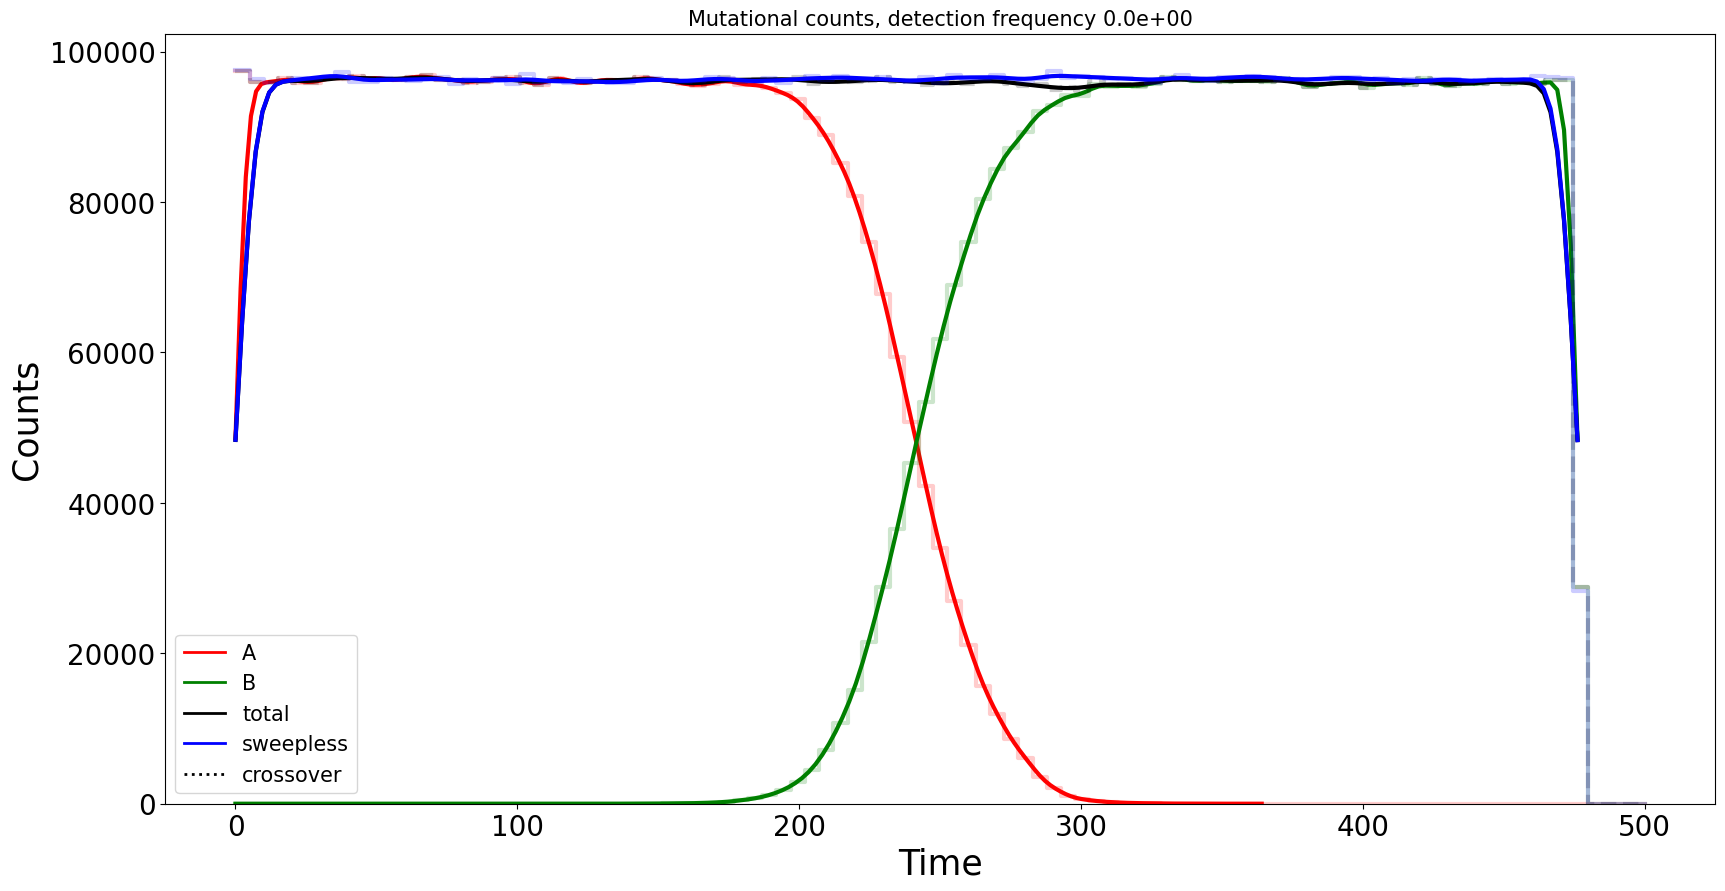

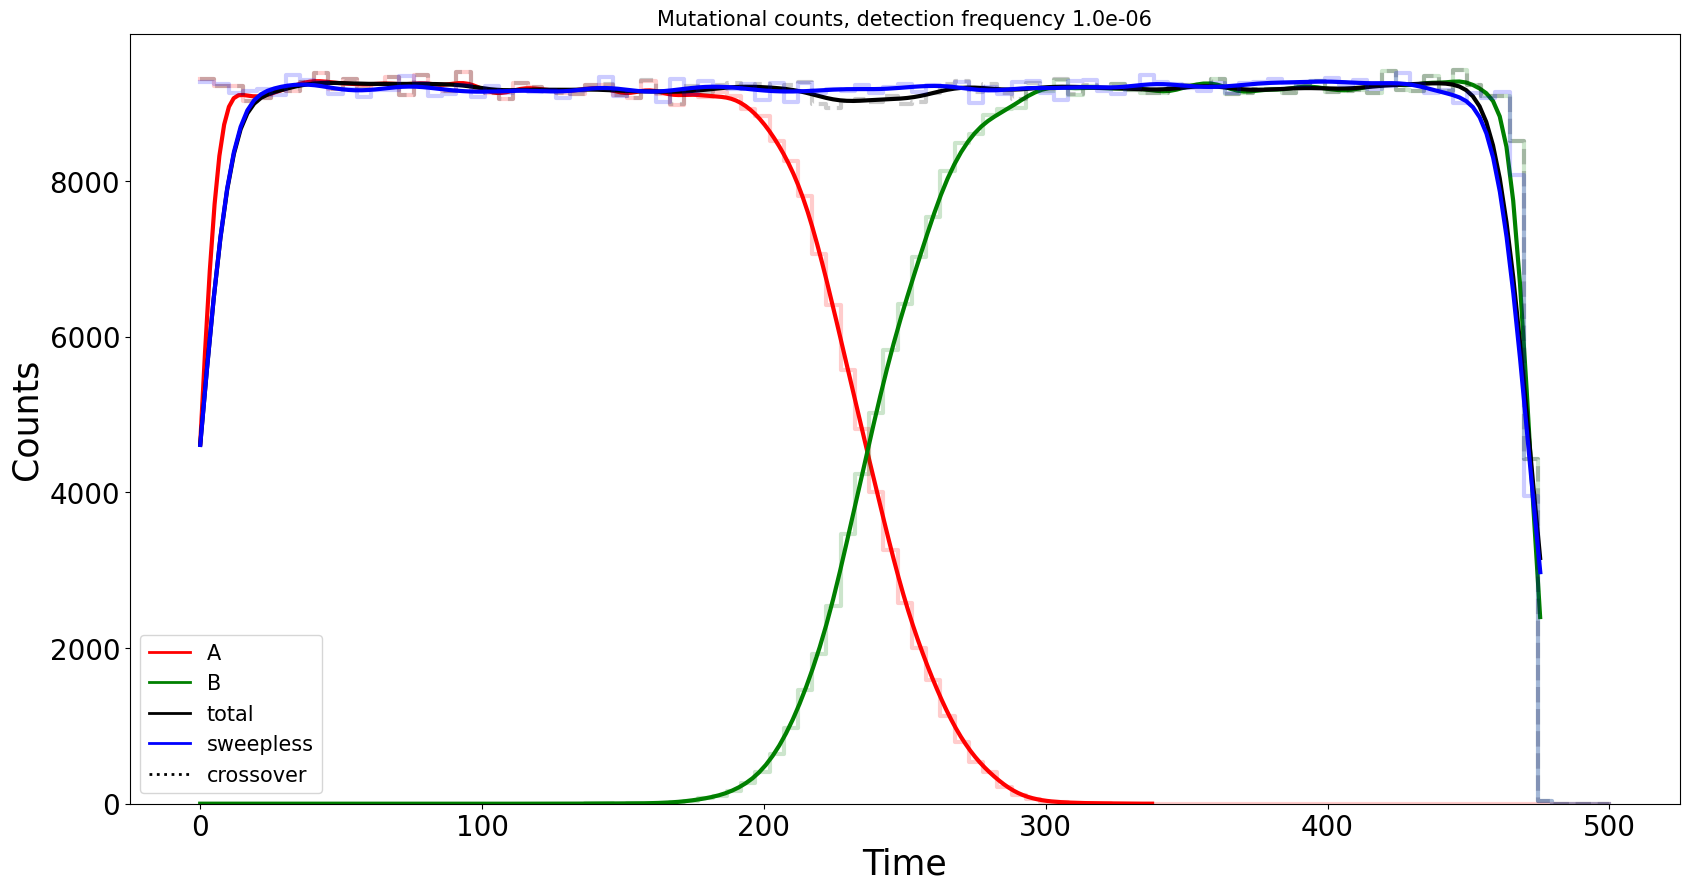

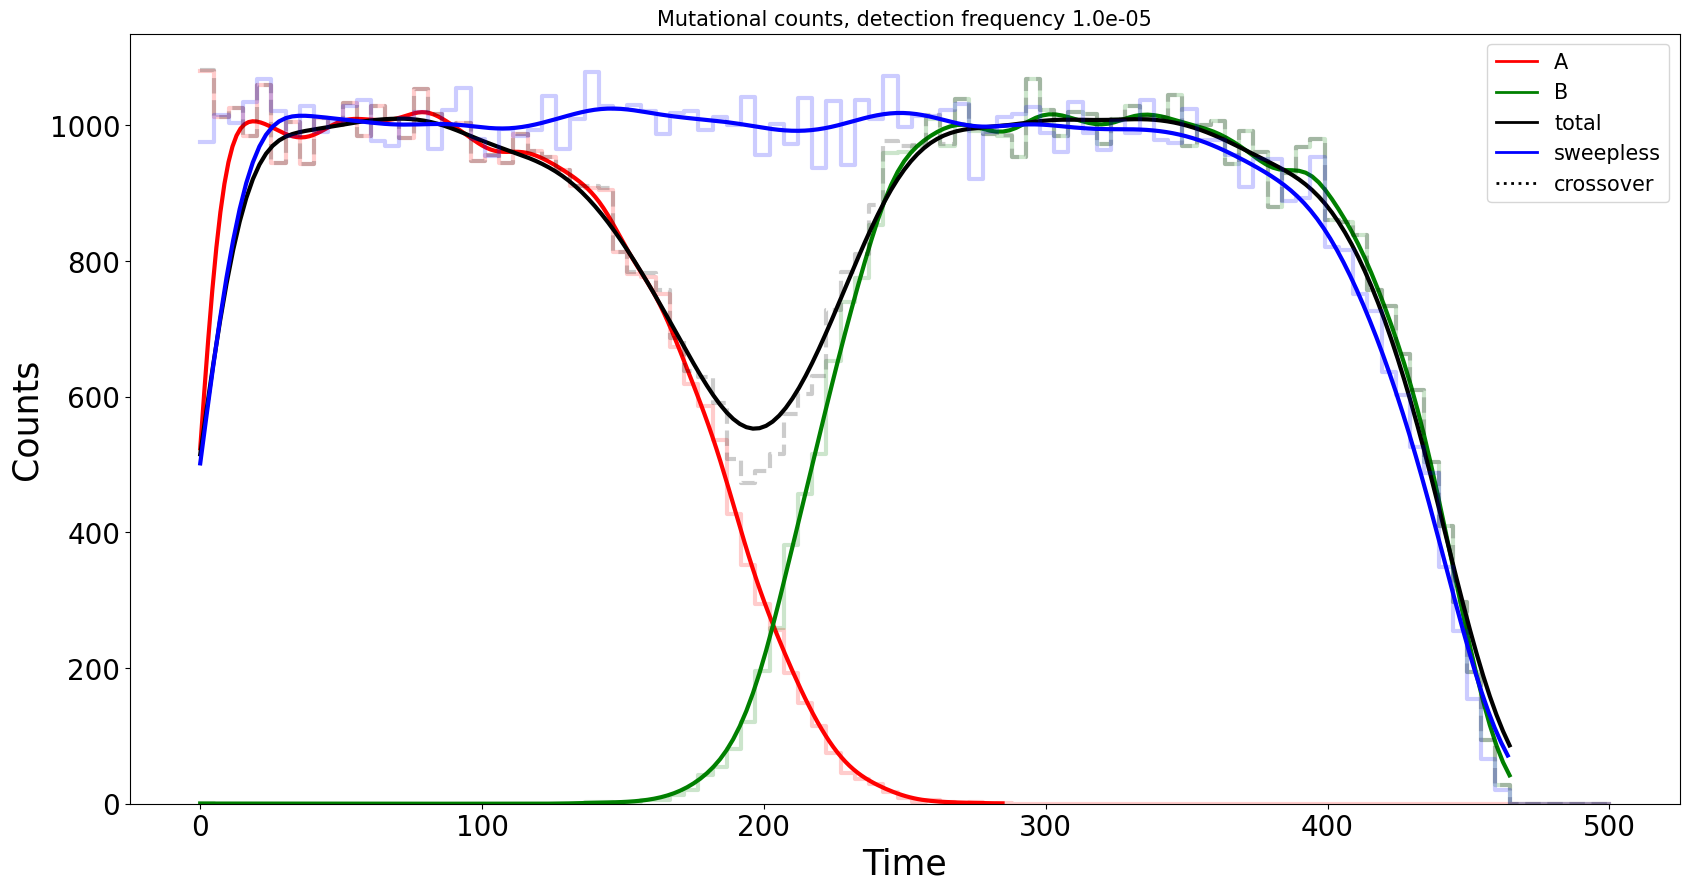

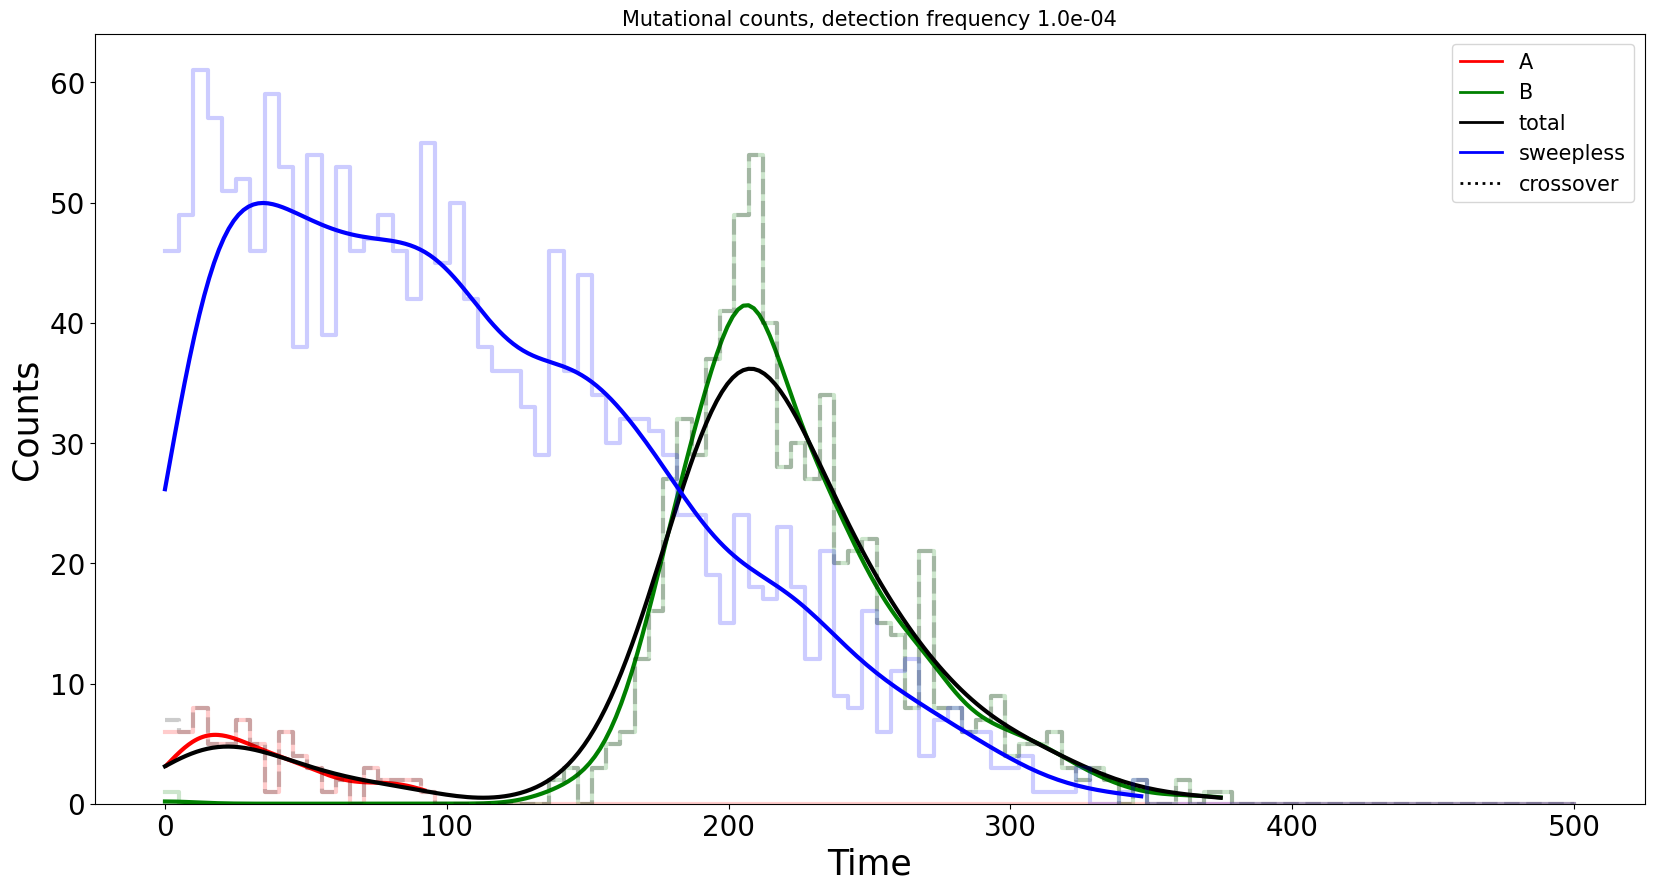

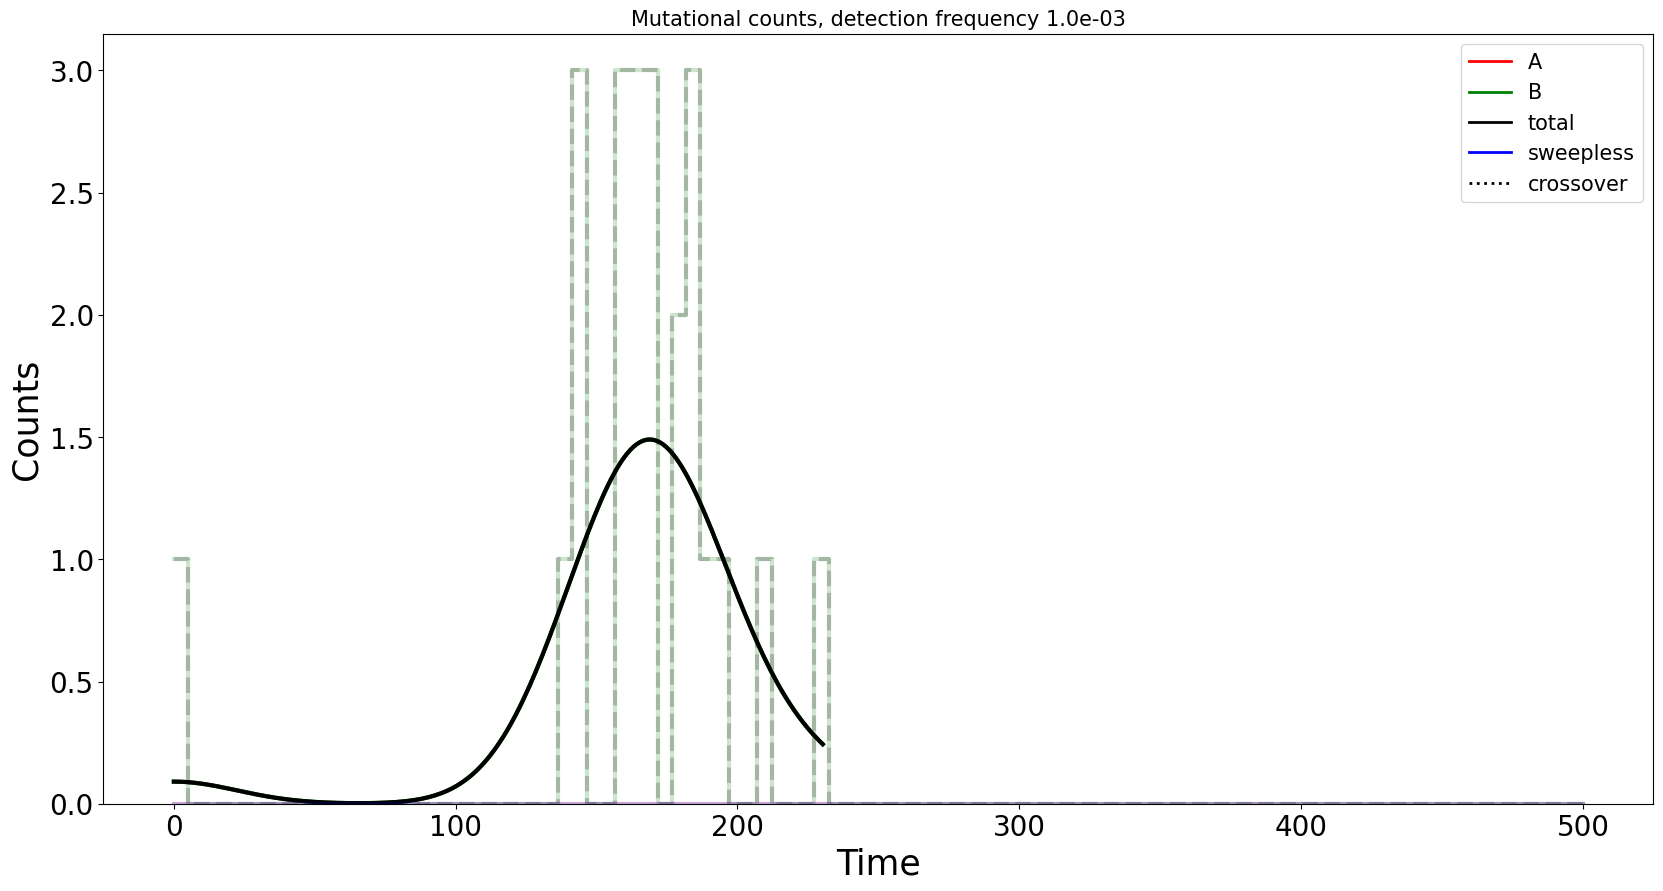

In [139]:
tbins = np.linspace(0,500,100)
deltabin = tbins[1]-tbins[0]
for detection_n in tqdm([0,10,100,1000,1e4]):
    fig,ax= plt.subplots(1,1,figsize=(20,10))
    detection_x = detection_n/N
    sns.histplot(data=df_with_sweep.query(f'bckg == "A" & max_freq>{detection_x} & max_freq < .95'), x='t0', bins=tbins,color='red',ax=ax,fill=False,element='step',kde=True,alpha=.2, label = 'A')
    sns.histplot(data=df_with_sweep.query(f'bckg == "B" & max_freq>{detection_x} & max_freq < .95'), x='t0', bins=tbins,color='green',ax=ax,fill=False,element='step',kde=True,alpha=.2, label = 'B')
    sns.histplot(data=df_with_sweep.query(f'max_freq > {detection_x} & max_freq < .95'), x='t0', bins=tbins,ax=ax,fill=False,element='step',kde=True,color='black',ls='--',alpha=.2, label = 'total')

    sns.histplot(data=df_without_sweep.query(f'max_freq > {detection_x} & max_freq < .95'), x='t0', bins=tbins,color='blue',ax=ax,fill=False,element='step',kde=True,alpha=.2, label = 'sweepless')
    # xb = N_Bs/N
    # xa = N_As/N
    # if detection_x>0:
    #     ax.plot(ts-np.sqrt(detection_n), xb* U/detection_x* deltabin, color='green', label='B',ls=':')
    #     ax.plot(ts, xa* U/detection_x* deltabin , color='red', label='A',ls=':')
    # # ax.set_xlim(100,400)
    # crossover_ind = np.where(N_Bs>N_As)[0][0]
    # ax.axvline(ts[crossover_ind],color='black',ls=':',label='crossover')
    ax.set_title(f'Mutational counts, detection frequency {detection_n/N:.1e}',fontsize=15)
    ax.set_xlabel('Time')
    ax.set_ylabel('Counts')
    handles = [Line2D([0], [0], color='red', lw=2, label='A'),
                Line2D([0], [0], color='green', lw=2, label='B'),
                Line2D([0], [0], color='black', lw=2, label='total'),
                Line2D([0], [0], color='blue', lw=2, label='sweepless'),
                Line2D([0], [0], color='black', lw=2, ls=':', label='crossover')]
    ax.legend(handles = handles,loc='best',fontsize=15)

In [151]:
df_without_sweep.query('max_freq < .95 & sim_ind ==4').count(), U*T*N

(t0          452521
 max_freq    452521
 sim_ind     452521
 bckg        452521
 dtype: int64,
 238150.00000000003)

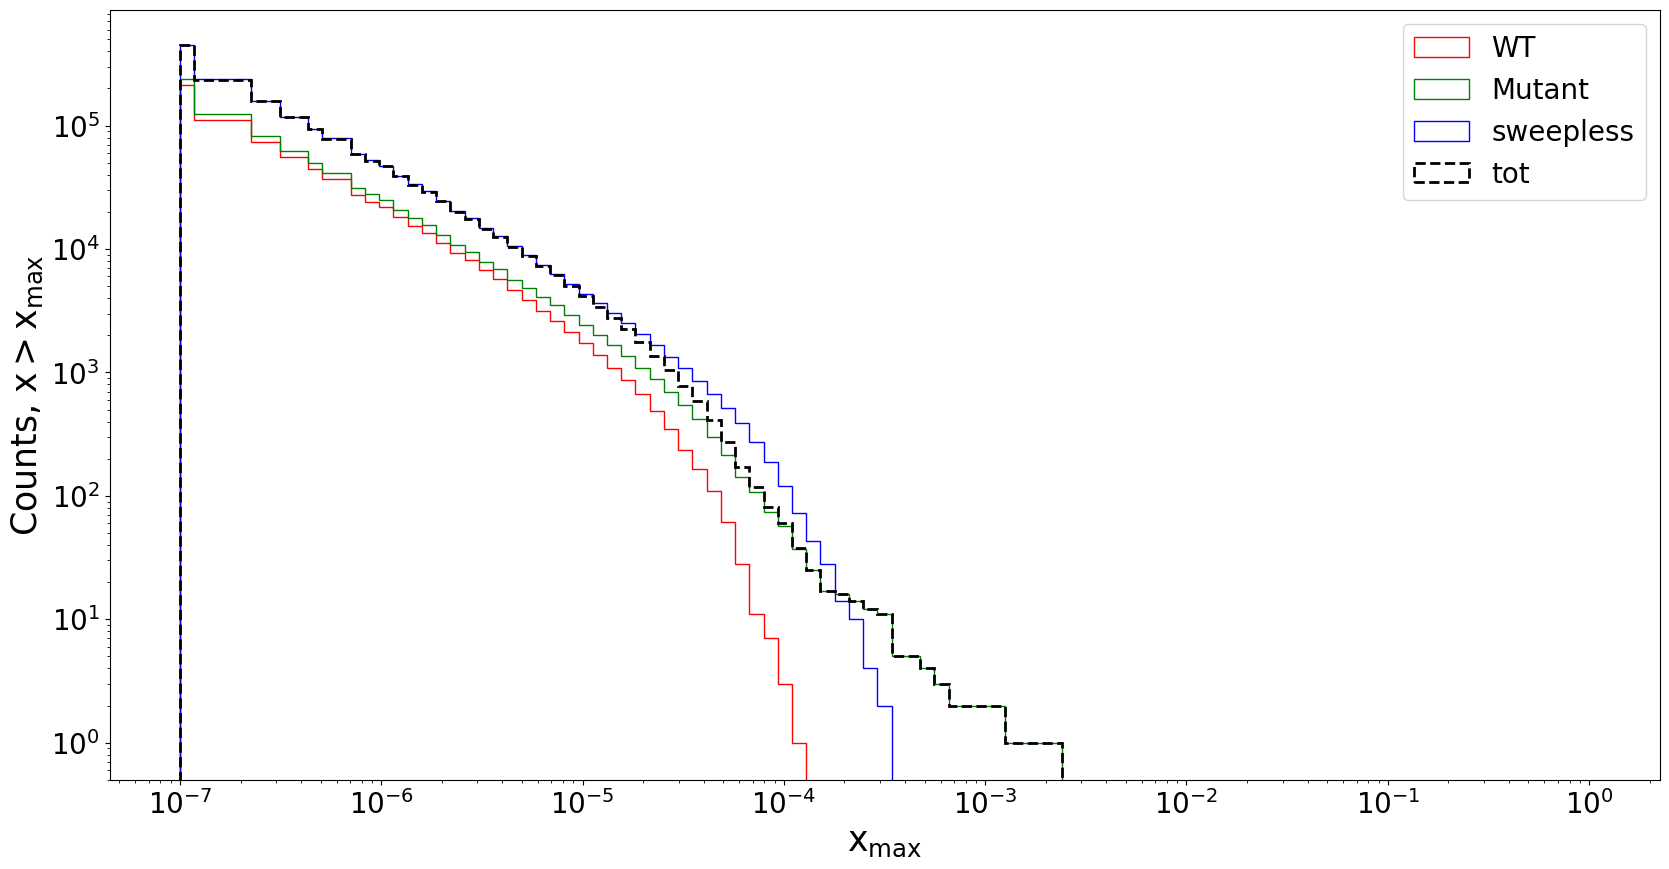

In [153]:
fig,ax= plt.subplots(1,1,figsize=(20,10))

h_A, b_A, p_A = plt.hist(df_with_sweep.query('bckg == "A" & max_freq < .95 & sim_ind ==4')['max_freq'],  density=False, bins = np.logspace(-7,0,100),cumulative=-1, fill=False,histtype= 'step',color='red',label = 'WT')
h_B, b_B, p_B = plt.hist(df_with_sweep.query('bckg == "B" & max_freq < .95 & sim_ind ==4')['max_freq'],  density=False, bins = np.logspace(-7,0,100),cumulative=-1, fill=False,histtype= 'step',color='green',label = 'Mutant')

h_A_sweepless, b_A_sweepless, p_A_sweepless = plt.hist(df_without_sweep.query('max_freq < .95 & sim_ind ==4')['max_freq'],  density=False, bins = np.logspace(-7,0,100),cumulative=-1, fill=False,histtype= 'step',color='blue',label = 'sweepless')

h_tot_A, b_tot_A, p_tot_A = plt.hist(df_with_sweep.query('max_freq < .95 & sim_ind ==4')['max_freq'],  density=False, bins = np.logspace(-7,0,100),cumulative=-1, fill=False,histtype= 'step',color='black',ls='--',label = 'tot',lw=2)

ax.set_xscale('log')
ax.set_yscale('log')

xbins = np.logspace(-7,0,100)
T = sweepless_sim.dt*sweepless_sim.N_t_steps 
# ax.plot(xbins, 2*U*(T- N*xbins)/xbins, color='red',label='WT')
# ax.axvline(sweepless_sim.dt* sweepless_sim.N_t_steps/sweepless_sim.N)
ax.set_ylabel(r'Counts, $x>x_\mathrm{max}$')
ax.set_ylim(bottom=.5)
ax.set_xlabel(r'$x_\mathrm{max}$')
ax.legend(loc='best')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,10))


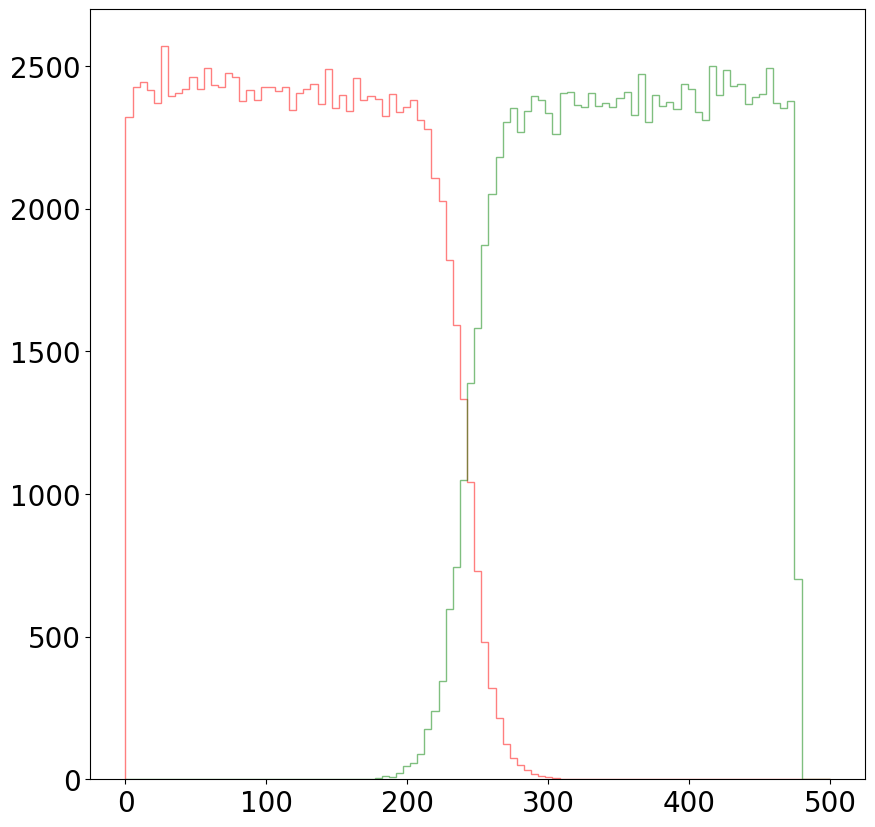

In [47]:
fig,ax= plt.subplots(1,1,figsize=(10,10))

tbins = np.linspace(0, 500, 100)

ax.hist(sim.t0s_A[sim.xmaxs_A>0], bins=tbins, alpha=0.5, label='A',color='red',histtype='step',fill = False)
ax.hist(sim.t0s_B[sim.xmaxs_B>0], bins=tbins, alpha=0.5, label='A',color='green',histtype='step',fill = False);


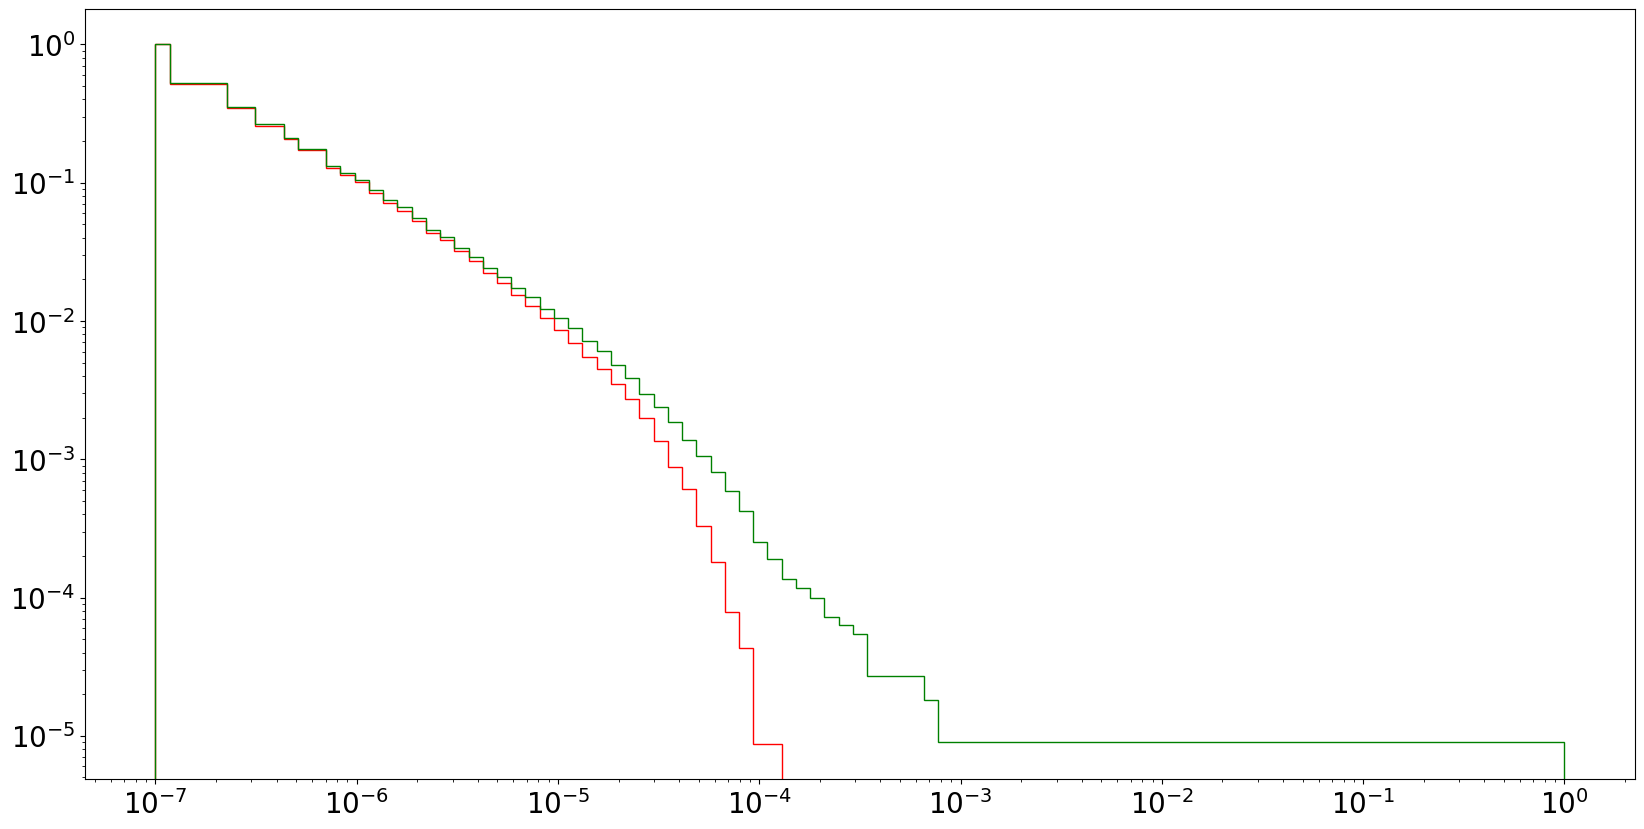

In [30]:
# fig,ax= plt.subplots()
# plt.hist(sim.xmaxs_A[np.logical_and(sim.xmaxs_A>0,sim.xmaxs_A<1-1/N)], bins = np.logspace(-7,0,100) , alpha=1, label='A', color='red',fill=False, histtype='step',density=True,cumulative=-1);
# plt.hist(sim.xmaxs_B[np.logical_and(sim.xmaxs_B>0,sim.xmaxs_B<1-1/N)], bins = np.logspace(-7,0,100) , alpha=1, label='B', color='green',fill=False, histtype='step',density=True,cumulative=-1);
# ax.set_yscale('log')
# ax.set_xscale('log')

In [9]:
old_df_with_sweep = sim.form_dataframe(A,B)

  0%|          | 0/207232 [00:00<?, ?it/s]/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_28366/3095323295.py:112: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mutants_df_with_sweep = pd.concat([mutants_df_with_sweep, pd.DataFrame([[t0, max_freq, bckg]], columns=['t0', 'max_freq', 'bckg'])])
100%|██████████| 207232/207232 [01:23<00:00, 2492.43it/s] 


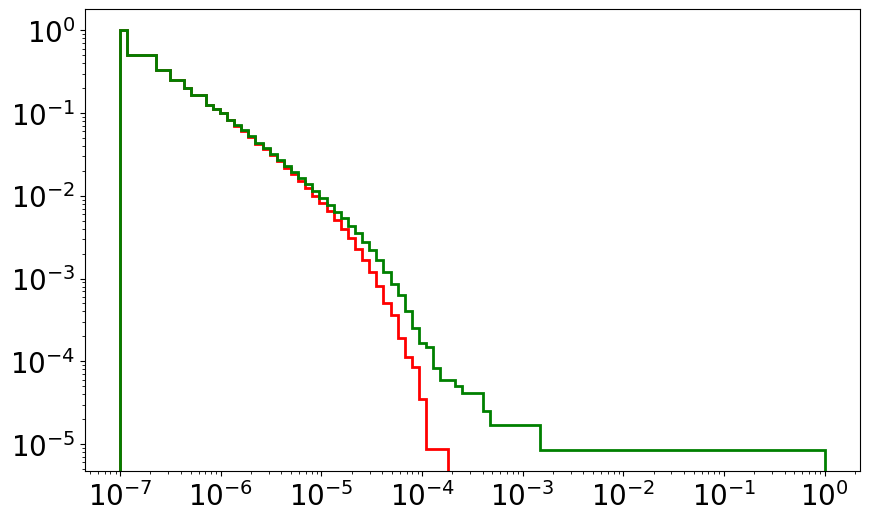

In [10]:
fig,ax= plt.subplots(1,1,figsize=(10,6))
# fig,ax= plt.subplots(1,1,figsize=(5,5))
xbins = np.logspace(-7,0,100)
A_h,A_b,A_p = ax.hist(old_df_with_sweep.query('bckg == "A"')['max_freq'], bins = xbins, density = True, alpha = 1, lw=2, cumulative=-1, histtype = 'step',color='red', label = 'A')
B_h,B_b,B_p = ax.hist(old_df_with_sweep.query('bckg == "B"')['max_freq'], bins = xbins, density = True, alpha = 1, lw=2, cumulative=-1, histtype = 'step',color='green', label = 'B')



ax.set_xscale('log')
ax.set_yscale('log')

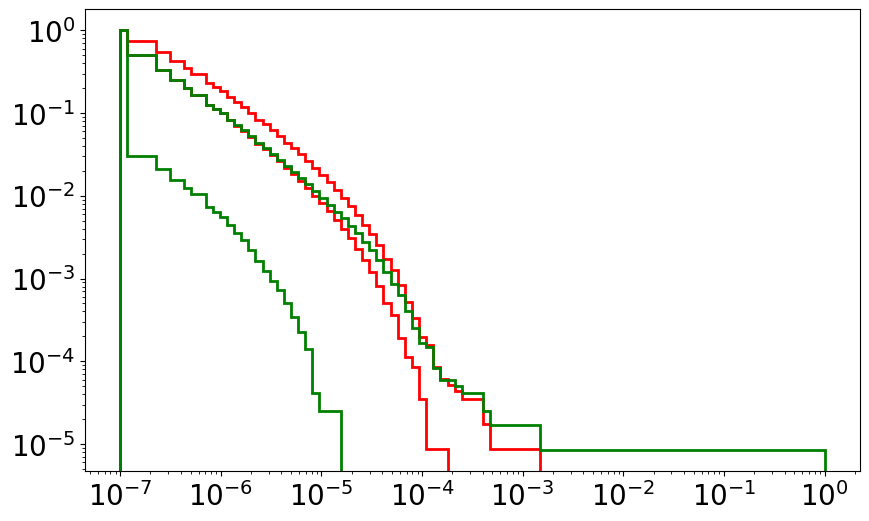

In [11]:
fig,ax= plt.subplots(1,1,figsize=(10,6))
# fig,ax= plt.subplots(1,1,figsize=(5,5))
xbins = np.logspace(-7,0,100)
A_h,A_b,A_p = ax.hist(neo_df_with_sweep.query('bckg == "A"')['max_freq'], bins = xbins, density = True, alpha = 1, lw=2, cumulative=-1, histtype = 'step',color='red', label = 'A')
B_h,B_b,B_p = ax.hist(neo_df_with_sweep.query('bckg == "B"')['max_freq'], bins = xbins, density = True, alpha = 1, lw=2, cumulative=-1, histtype = 'step',color='green', label = 'B')

A_h,A_b,A_p = ax.hist(old_df_with_sweep.query('bckg == "A"')['max_freq'], bins = xbins, density = True, alpha = 1, lw=2, cumulative=-1, histtype = 'step',color='red', label = 'A')
B_h,B_b,B_p = ax.hist(old_df_with_sweep.query('bckg == "B"')['max_freq'], bins = xbins, density = True, alpha = 1, lw=2, cumulative=-1, histtype = 'step',color='green', label = 'B')


ax.set_xscale('log')
ax.set_yscale('log')

In [38]:
df_with_sweep = pd.read_feather('data/sweep_data.feather')

In [17]:
# for i in range(6):
sweepless_sim  =sweepless_Simulation(s, U, N, dt, step_appearance=2000)
A_sweepless = sweepless_sim.run()
df= sweepless_sim.form_dataframe(A_sweepless)

for i in range(5):
    sweepless_sim = sweepless_Simulation(s, U, N, dt, step_appearance=2000)
    A_sweepless = sweepless_sim.run()
    df= pd.concat([df,sweepless_sim.form_dataframe(A_sweepless)])
    df.to_feather('data/sweepless_data.feather')


  0%|          | 0/276310 [00:00<?, ?it/s]/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_20155/2489915369.py:167: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mutants_df_without_sweep = pd.concat([mutants_df_without_sweep, pd.DataFrame([[t0, max_freq]], columns=['t0', 'max_freq'])])
  0%|          | 0/276310 [00:00<?, ?it/s]/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_20155/2489915369.py:167: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mutants_df_without_sweep = pd.c

In [20]:
df_sweepless = df

<Axes: xlabel='t0', ylabel='Count'>

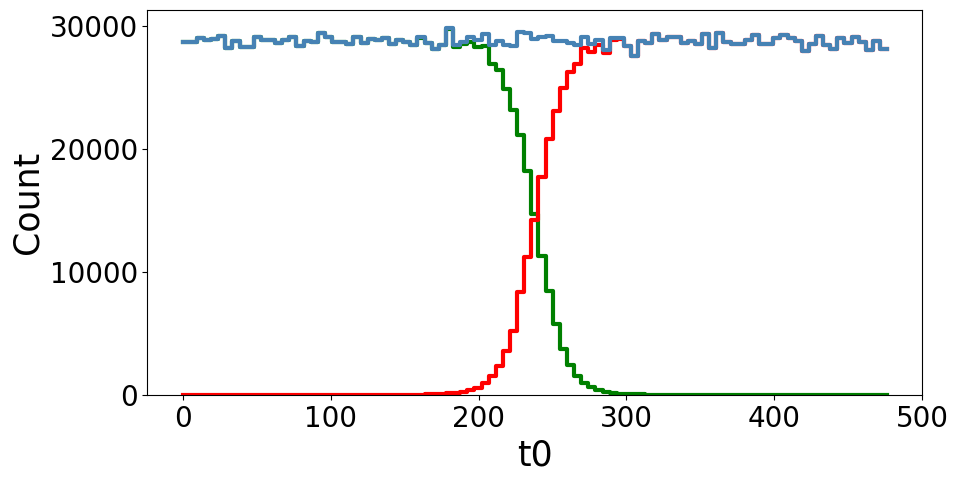

In [50]:
bins = np.linspace(0,df_with_sweep.t0.max(),100)
fig,ax=plt.subplots(1,1,figsize=(10,5))
sns.histplot(data=df_with_sweep.query('bckg == "A"'), x='t0', bins=bins,color='green',ax=ax,fill=False,element='step')
sns.histplot(data=df_with_sweep.query('bckg == "B"'), x='t0', bins=bins,color='red',ax=ax,fill=False,element='step')
sns.histplot(data=df_with_sweep, x='t0', bins=bins,color='steelblue',ax=ax,fill=False,element='step')

# sns.histplot(data=df_sweepless, x='t0', bins=bins,color='blue',ax=ax,fill=False,element='step')


In [7]:
sweepless_sim = sweepless_Simulation(s, U, N, dt, step_appearance=2000)
A_sweepless = sweepless_sim.run()


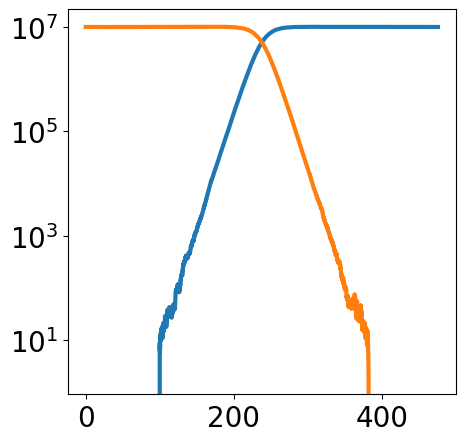

In [9]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
N_As = np.sum(A,axis=1)
N_Bs = np.sum(B,axis=1)
ts = np.arange(0, sim.N_t_steps)*sim.dt
ax.plot(ts,N_Bs, label='A')
ax.plot(ts,N_As, label='A')
ax.set_yscale('log')

Text(0, 0.5, 'P(max freq > x)')

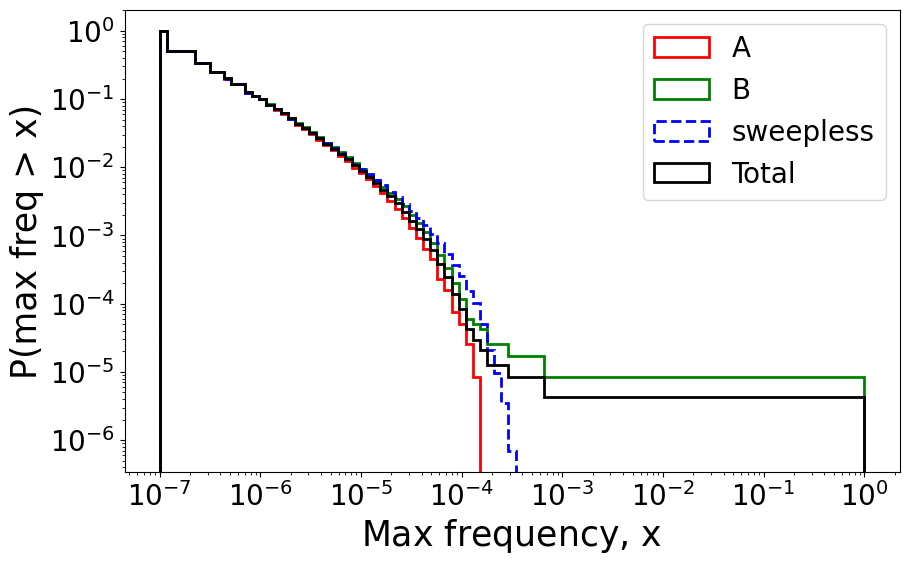

In [32]:
fig,ax= plt.subplots(1,1,figsize=(10,6))
# fig,ax= plt.subplots(1,1,figsize=(5,5))
xbins = np.logspace(-7,0,100)
A_h,A_b,A_p = ax.hist(df_with_sweep.query('bckg == "A"')['max_freq'], bins = xbins, density = True, alpha = 1, lw=2, cumulative=-1, histtype = 'step',color='red', label = 'A')
B_h,B_b,B_p = ax.hist(df_with_sweep.query('bckg == "B"')['max_freq'], bins = xbins, density = True, alpha = 1, lw=2, cumulative=-1, histtype = 'step',color='green', label = 'B')
# total_h,total_b,total_p = ax.hist(df_with_sweep['max_freq'], bins = xbins, density = True, alpha = 1, lw=2, cumulative=-1, histtype = 'step',color='black')

sweepless_A_h,sweepless_A_b,sweepless_A_p = ax.hist(df_sweepless['max_freq'], bins = xbins, density = True, alpha = 1, lw=2, cumulative=-1, histtype = 'step',color='blue',ls='--', label = 'sweepless')

total_h,total_b,total_p = ax.hist(df_with_sweep['max_freq'], bins = xbins, density = True, alpha = 1, lw=2, cumulative=-1, histtype = 'step',color='black', label = 'Total')

# ax.plot(xbins, 1e5*xbins[0]/xbins,ls = '--', color='black', lw=2)
# ax.plot(xbins, xbins**(-2)/N,ls = '--', color='black', lw=2)
# ax.set_xlim(1/N,1e-3)
# ax.set_ylim(1e-5,1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='best')
ax.set_xlabel(r'Max frequency, $x$')
ax.set_ylabel('P(max freq > x)')


Text(0, 0.5, 'P(max freq > x)')

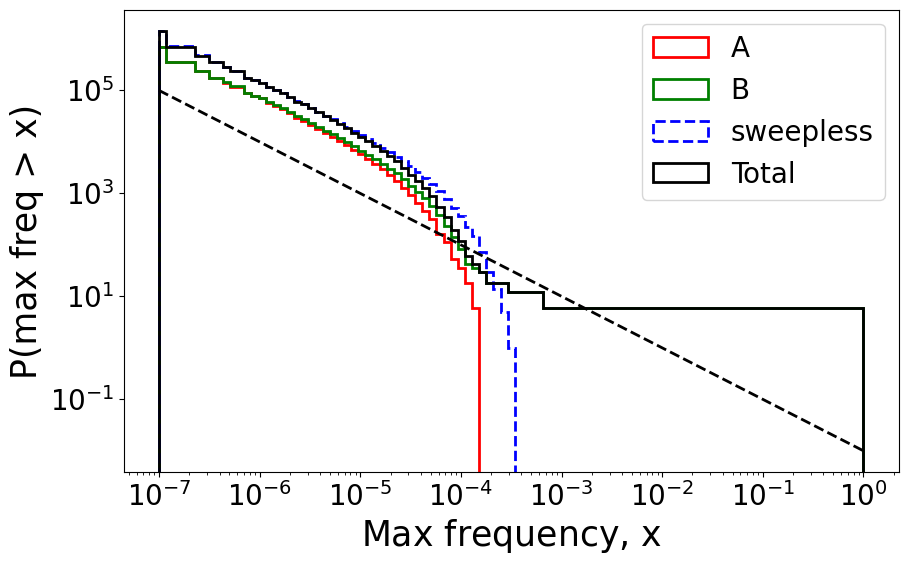

In [23]:
fig,ax= plt.subplots(1,1,figsize=(10,6))
# fig,ax= plt.subplots(1,1,figsize=(5,5))
xbins = np.logspace(-7,0,100)
A_h,A_b,A_p = ax.hist(df_with_sweep.query('bckg == "A"')['max_freq'], bins = xbins, density = False, alpha = 1, lw=2, cumulative=-1, histtype = 'step',color='red', label = 'A')
B_h,B_b,B_p = ax.hist(df_with_sweep.query('bckg == "B"')['max_freq'], bins = xbins, density = False, alpha = 1, lw=2, cumulative=-1, histtype = 'step',color='green', label = 'B')
# total_h,total_b,total_p = ax.hist(df_with_sweep['max_freq'], bins = xbins, density = False, alpha = 1, lw=2, cumulative=-1, histtype = 'step',color='black')

sweepless_A_h,sweepless_A_b,sweepless_A_p = ax.hist(df_sweepless['max_freq'], bins = xbins, density = False, alpha = 1, lw=2, cumulative=-1, histtype = 'step',color='blue',ls='--', label = 'sweepless')

total_h,total_b,total_p = ax.hist(df_with_sweep['max_freq'], bins = xbins, density = False, alpha = 1, lw=2, cumulative=-1, histtype = 'step',color='black', label = 'Total')

ax.plot(xbins, 1e5*xbins[0]/xbins,ls = '--', color='black', lw=2)
# ax.plot(xbins, xbins**(-2)/N,ls = '--', color='black', lw=2)
# ax.set_xlim(1/N,1e-3)
# ax.set_ylim(1e-5,1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='best')
ax.set_xlabel(r'Max frequency, $x$')
ax.set_ylabel('P(max freq > x)')

In [30]:
s

0.1

Text(0, 0.5, 'P(max freq > x)')

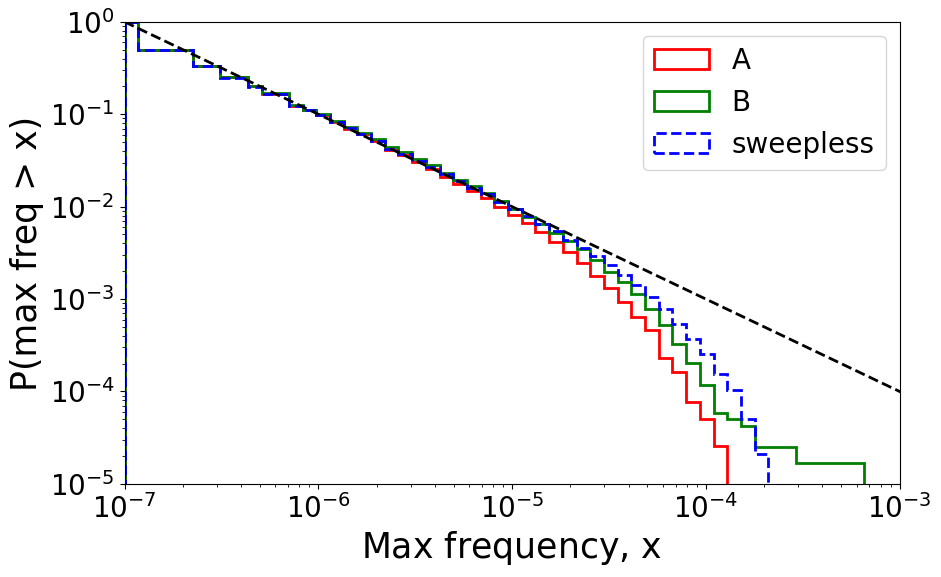

In [24]:
fig,ax= plt.subplots(1,1,figsize=(10,6))
# fig,ax= plt.subplots(1,1,figsize=(5,5))
xbins = np.logspace(-7,0,100)
A_h,A_b,A_p = ax.hist(df_with_sweep.query('bckg == "A"')['max_freq'], bins = xbins, density = True, alpha = 1, lw=2, cumulative=-1, histtype = 'step',color='red', label = 'A')
B_h,B_b,B_p = ax.hist(df_with_sweep.query('bckg == "B"')['max_freq'], bins = xbins, density = True, alpha = 1, lw=2, cumulative=-1, histtype = 'step',color='green', label = 'B')
# total_h,total_b,total_p = ax.hist(df_with_sweep['max_freq'], bins = xbins, density = True, alpha = 1, lw=2, cumulative=-1, histtype = 'step',color='black')

sweepless_A_h,sweepless_A_b,sweepless_A_p = ax.hist(df_sweepless['max_freq'], bins = xbins, density = True, alpha = 1, lw=2, cumulative=-1, histtype = 'step',color='blue',ls='--', label = 'sweepless')

ax.plot(xbins, xbins[0]/xbins,ls = '--', color='black', lw=2)
# ax.plot(xbins, xbins**(-2)/N,ls = '--', color='black', lw=2)
ax.set_xlim(1/N,1e-3)
ax.set_ylim(1e-5,1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='best')
ax.set_xlabel(r'Max frequency, $x$')
ax.set_ylabel('P(max freq > x)')

100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


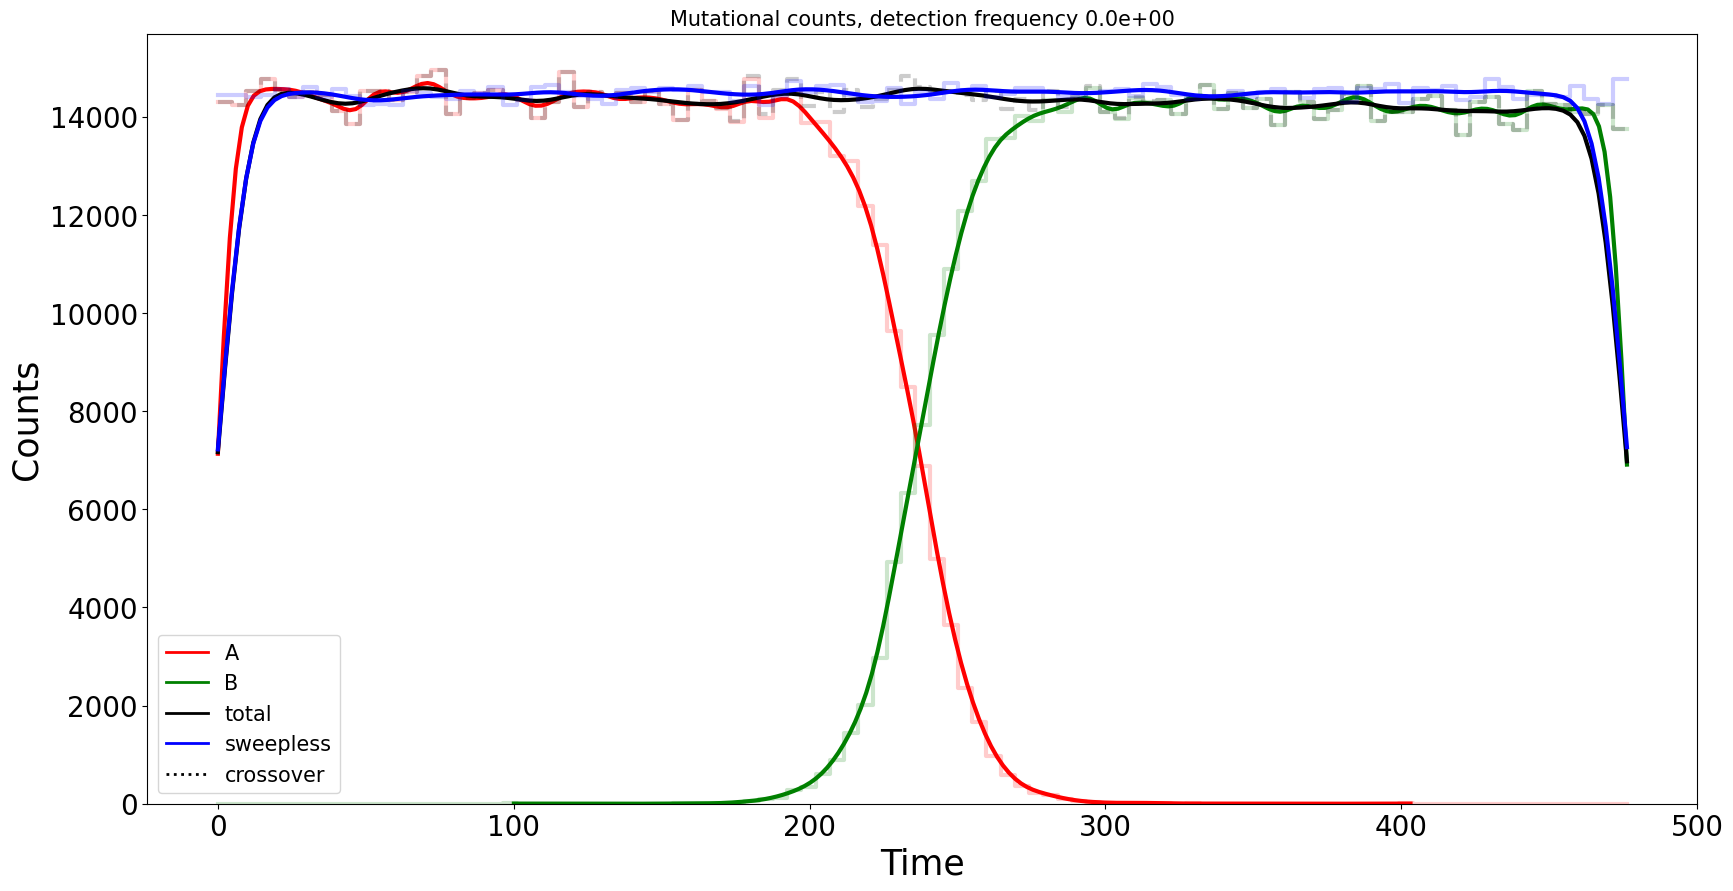

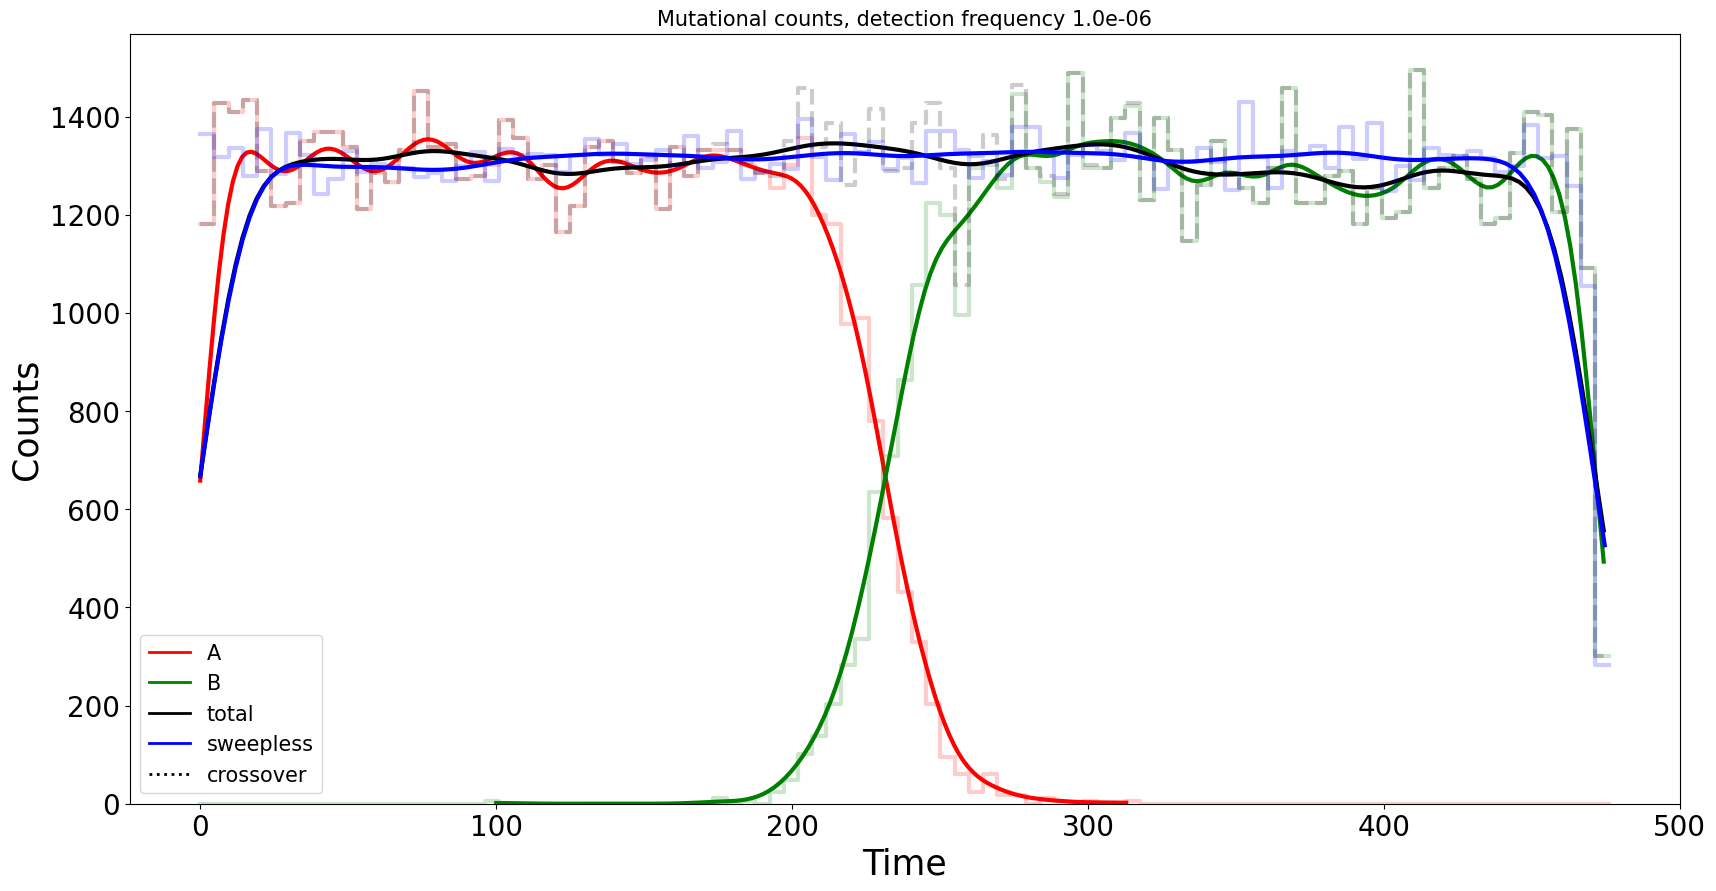

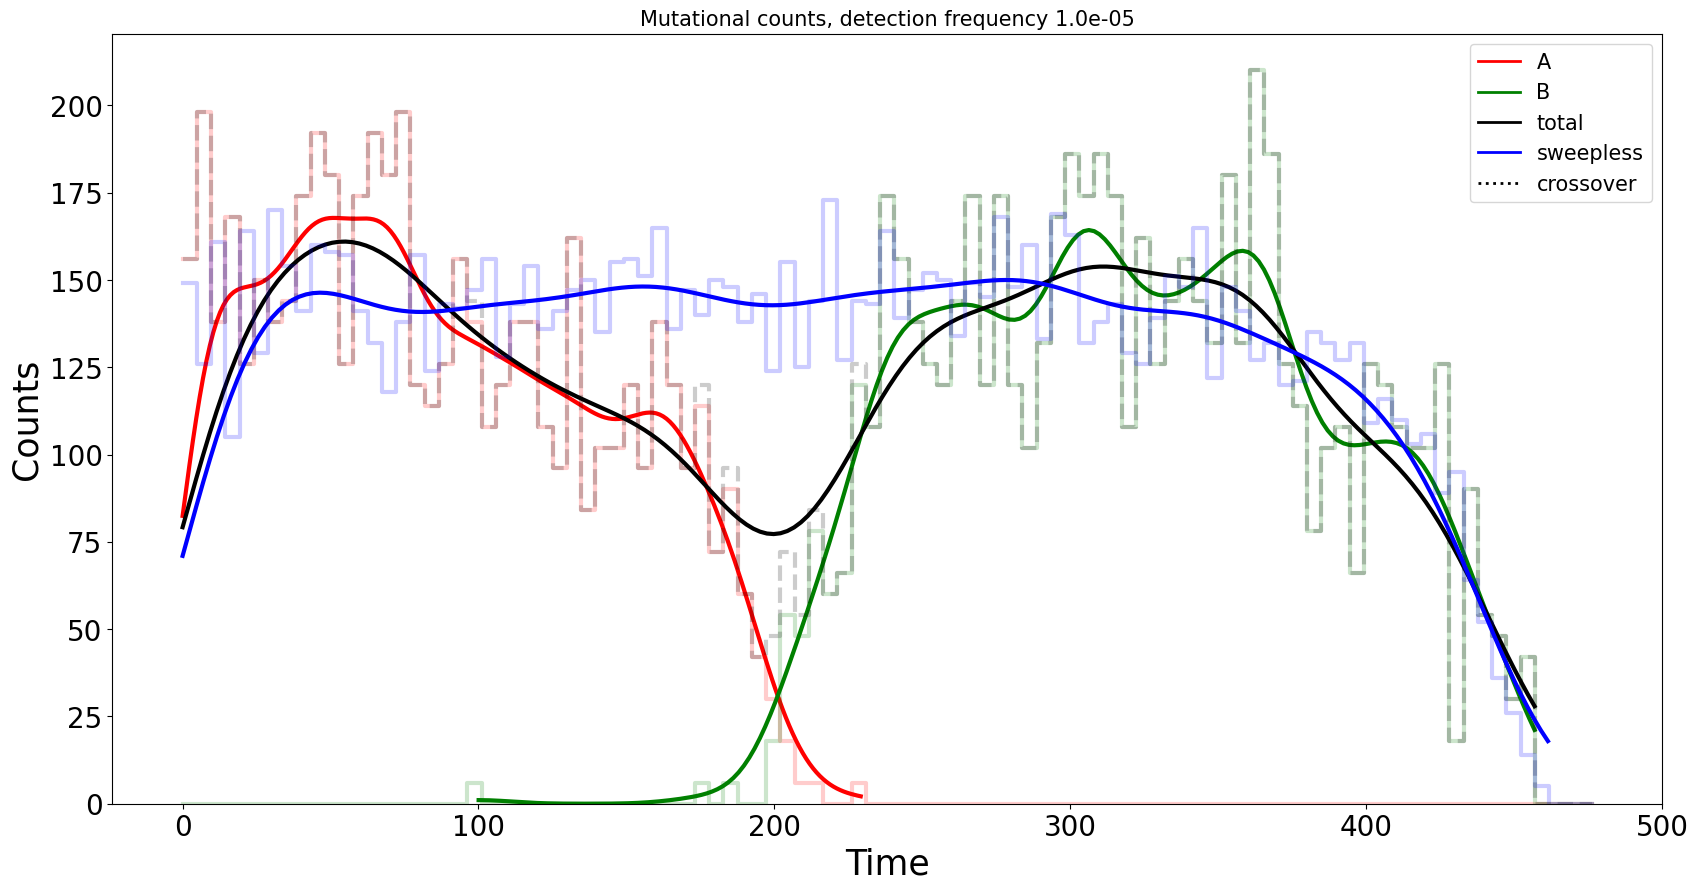

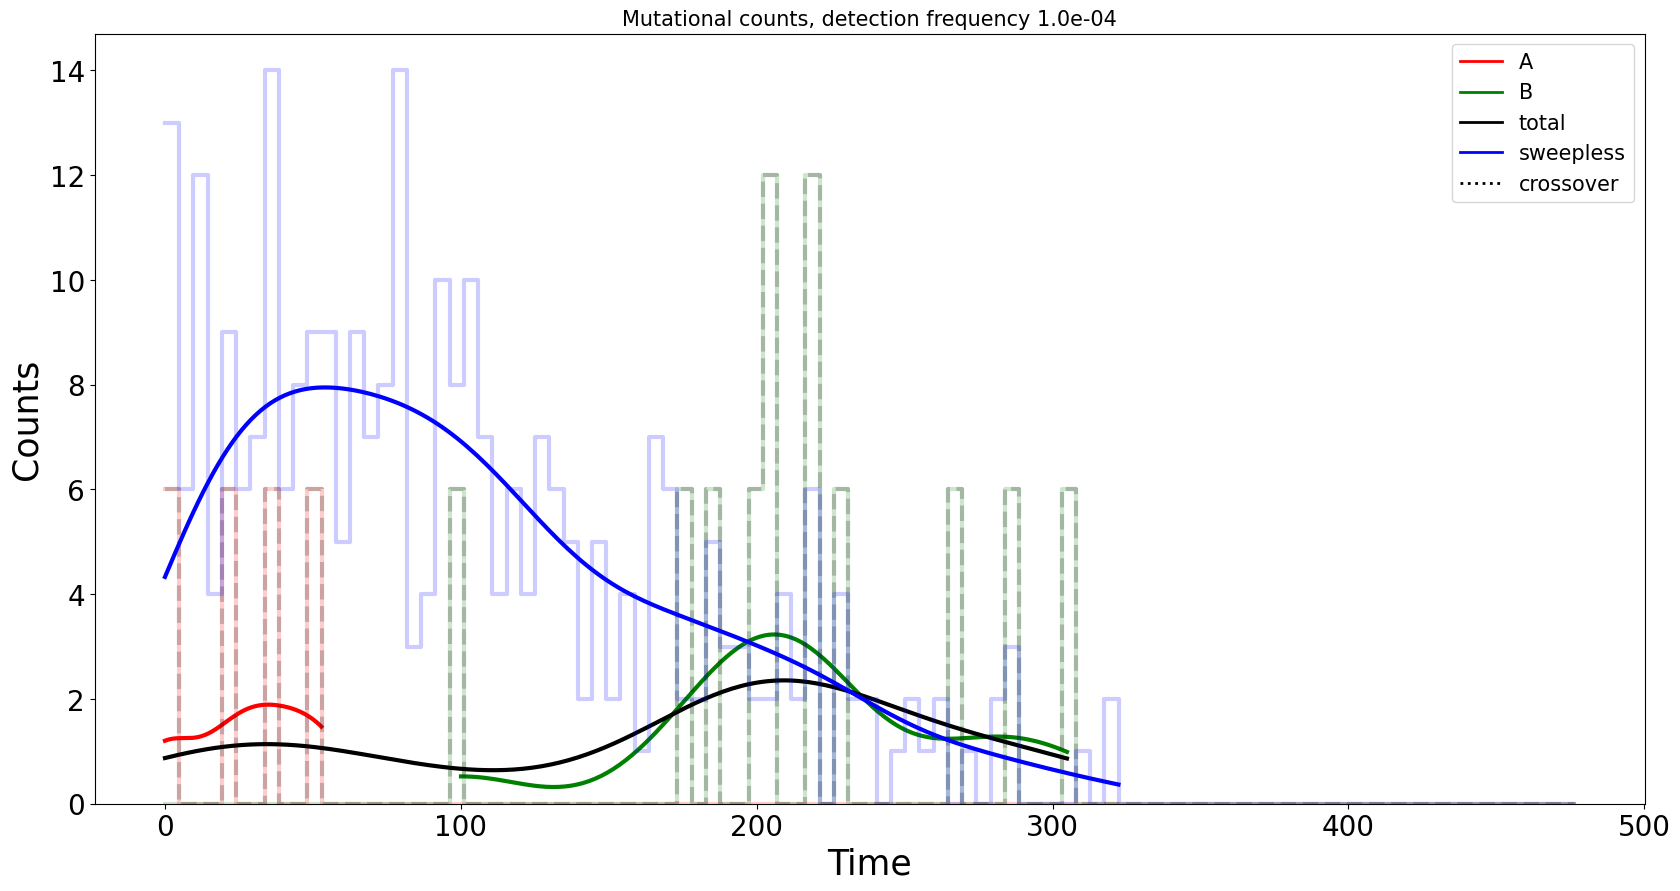

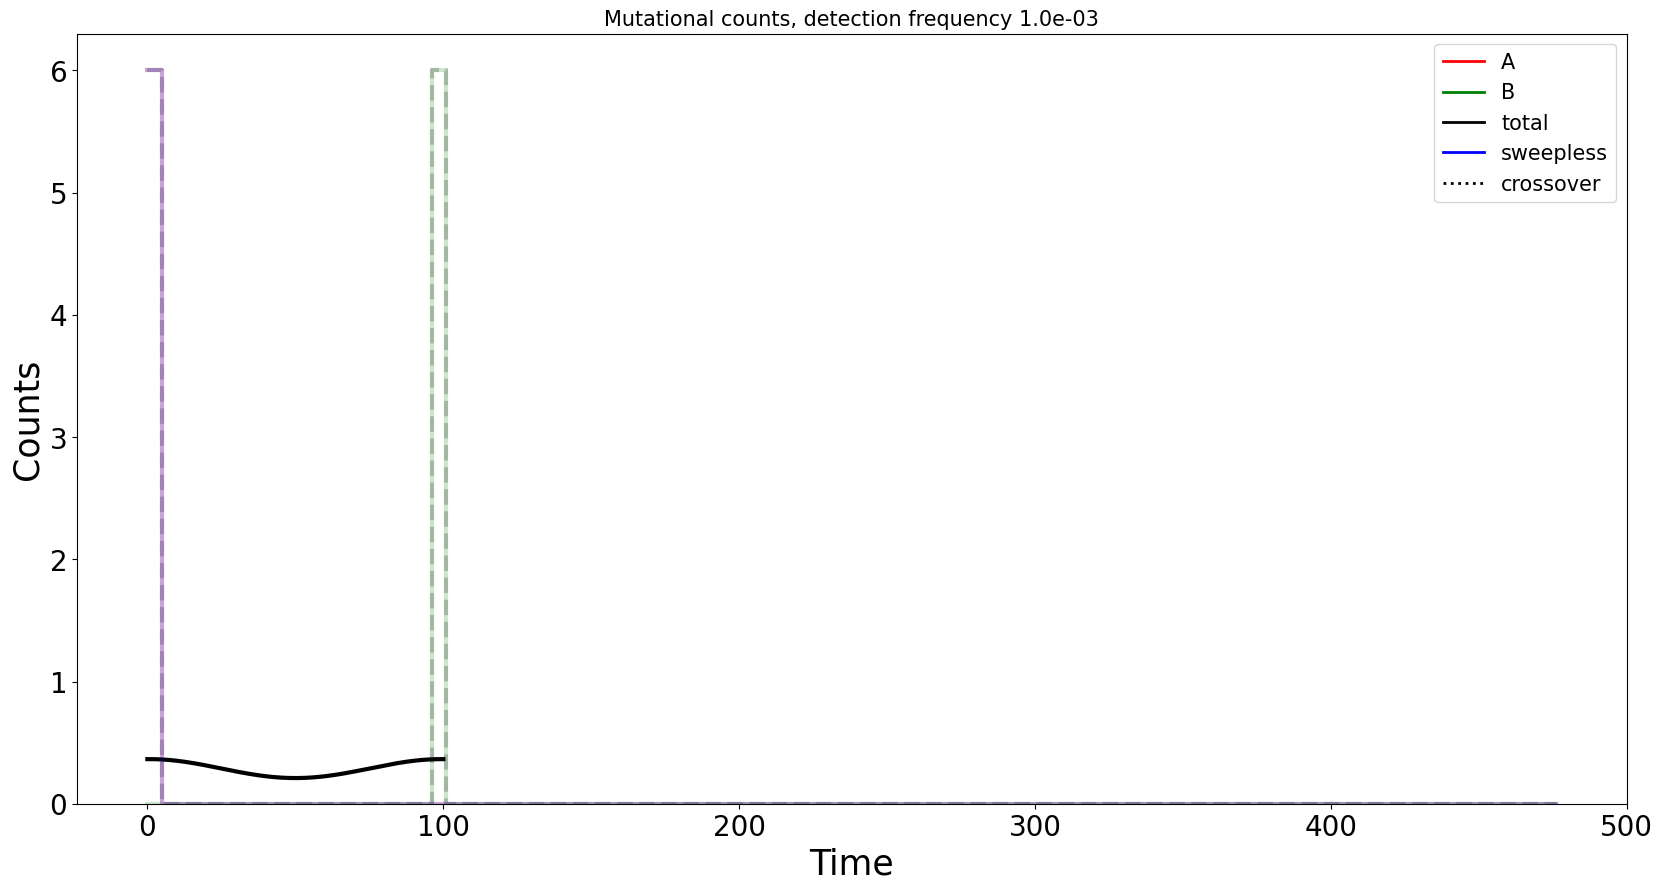

In [27]:
deltabin = bins[1]-bins[0]
for detection_n in tqdm([0,10,100,1000,1e4]):
    fig,ax= plt.subplots(1,1,figsize=(20,10))
    detection_x = detection_n/N
    sns.histplot(data=df_with_sweep.query(f'bckg == "A" & max_freq>{detection_x}'), x='t0', bins=bins,color='red',ax=ax,fill=False,element='step',kde=True,alpha=.2, label = 'A')
    sns.histplot(data=df_with_sweep.query(f'bckg == "B" & max_freq>{detection_x}'), x='t0', bins=bins,color='green',ax=ax,fill=False,element='step',kde=True,alpha=.2, label = 'B')
    sns.histplot(data=df_with_sweep.query(f'max_freq > {detection_x}'), x='t0', bins=bins,ax=ax,fill=False,element='step',kde=True,color='black',ls='--',alpha=.2, label = 'total')

    sns.histplot(data=df_sweepless.query(f'max_freq > {detection_x}'), x='t0', bins=bins,color='blue',ax=ax,fill=False,element='step',kde=True,alpha=.2, label = 'sweepless')
    # xb = N_Bs/N
    # xa = N_As/N
    # if detection_x>0:
    #     ax.plot(ts-np.sqrt(detection_n), xb* U/detection_x* deltabin, color='green', label='B',ls=':')
    #     ax.plot(ts, xa* U/detection_x* deltabin , color='red', label='A',ls=':')
    # # ax.set_xlim(100,400)
    # crossover_ind = np.where(N_Bs>N_As)[0][0]
    # ax.axvline(ts[crossover_ind],color='black',ls=':',label='crossover')
    ax.set_title(f'Mutational counts, detection frequency {detection_n/N:.1e}',fontsize=15)
    ax.set_xlabel('Time')
    ax.set_ylabel('Counts')
    handles = [Line2D([0], [0], color='red', lw=2, label='A'),
                Line2D([0], [0], color='green', lw=2, label='B'),
                Line2D([0], [0], color='black', lw=2, label='total'),
                Line2D([0], [0], color='blue', lw=2, label='sweepless'),
                Line2D([0], [0], color='black', lw=2, ls=':', label='crossover')]
    ax.legend(handles = handles,loc='best',fontsize=15)

In [ ]:

tb_A_hist_list= {}
tb_B_hist_list = {}
tot_ts_hist_list = {}

NameError: name 'tot_ts_hist_list' is not defined

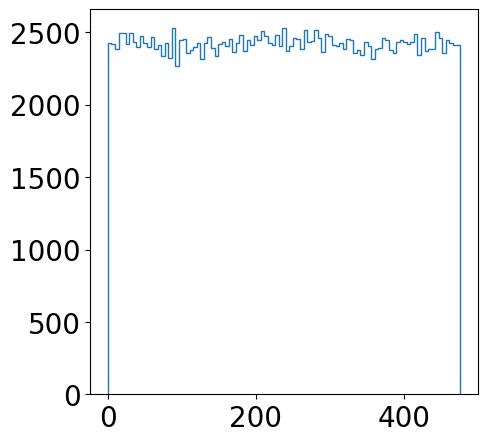

In [97]:
tb_A = [ts[A[:,i]>0][0] for i in range(A.shape[1]) if np.sum(A[:,i])>0]
tb_B = [ts[B[:,i]>0][0] for i in range(B.shape[1]) if np.sum(B[:,i])>0]

tot_ts=  np.concatenate([tb_A,tb_B])

bins = np.linspace(0, ts[-1], 100)
fig,ax = plt.subplots(1,1,figsize=(5,5))
tot_ts_hist_list[0] = ax.hist(tot_ts, bins=bins,histtype='step')
tb_B_hist_list [0] = ax.hist(tb_B, bins=bins,color='green',histtype='step')
tb_A_hist_list[0] = ax.hist(tb_A, bins=bins,color='red', alpha=0.5,histtype='step')

fig.suptitle(f'N={N:.1e}, U={U:.1e}, s={s}, dt={dt}',fontsize=20, y=1.08)
ax.set_xlabel('time to mutation',fontsize=20)
ax.set_ylabel('count',fontsize=20)
ax.set_title('Mutational counts, detection threshold = 0',fontsize=20)
tax = ax.twinx()
tax.plot(ts, N_As, color='red')
tax.plot(ts, N_Bs, color='green')
# tax.set_ylim(bottom=-1)
tax.set_yscale('log')
print(f'counts: {len(tb_A)}, {len(tb_B)}')
ax.set_yscale('log')

for detection_n in tqdm([100,250,500]):

    tb_A = [ts[A[:,i]>0][0] for i in range(A.shape[1]) if np.max(A[:,i])>=detection_n]
    tb_B = [ts[B[:,i]>0][0] for i in range(B.shape[1]) if np.max(B[:,i])>=detection_n]

    tot_ts=  np.concatenate([tb_A,tb_B])

    bins = np.linspace(0, ts[-1], 100)
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    tb_A_hist_list[detection_n] = ax.hist(tb_A, bins=bins,color='red', alpha=0.5,histtype='step')
    tb_B_hist_list [detection_n] = ax.hist(tb_B, bins=bins,color='green',histtype='step')
    tot_ts_hist_list[detection_n] = ax.hist(tot_ts, bins=bins,histtype='step')
    tax = ax.twinx()
    tax.plot(ts, N_As, color='green')
    tax.plot(ts, N_Bs, color='red')
    tax.set_ylim(bottom=-1)
    fig.suptitle(f'N={N:.1e}, U={U:.1e}, s={s}, dt={dt}',fontsize=20, y=1.08)
    ax.set_xlabel('time to mutation',fontsize=20)
    ax.set_ylabel('count',fontsize=20)
    ax.set_title(f'Mutational counts, detection number {detection_n}',fontsize=20)

    print(f'counts: {len(tb_A)}, {len(tb_B)}')

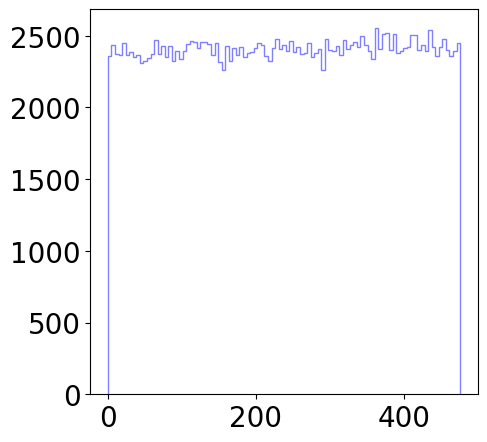

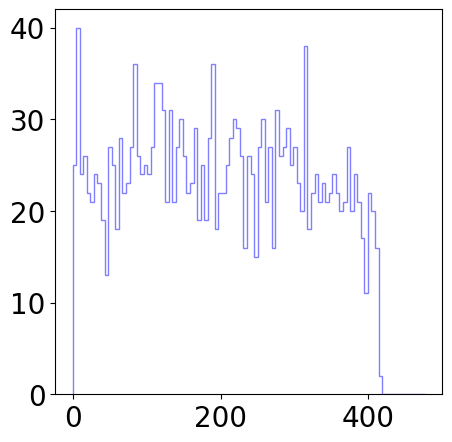

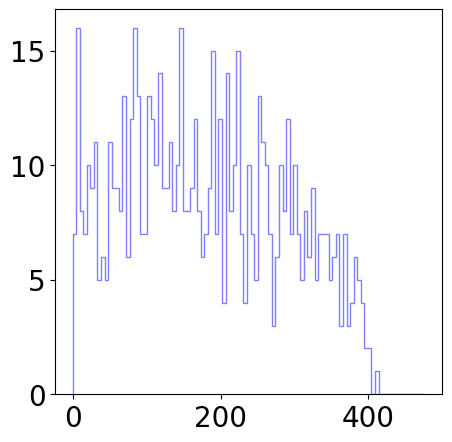

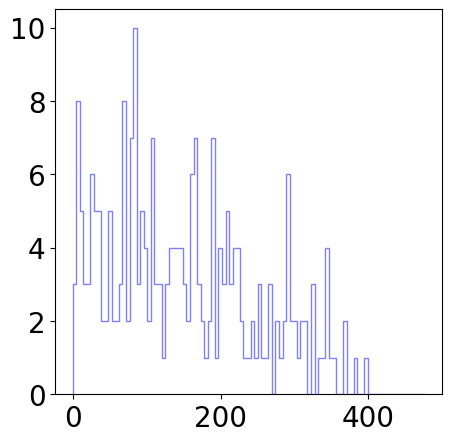

In [ ]:
tb_A_sweepless_hist_list= {}
fig,ax= plt.subplots(1,1,figsize=(5,5))
tb_A_sweepless = [ts[A_sweepless[:,i]>0][0] for i in range(A_sweepless.shape[1]) if np.sum(A_sweepless[:,i])>0]
tb_A_sweepless_hist_list[0] = ax.hist(tb_A_sweepless, bins=bins,color='blue', alpha=0.5,histtype='step')
for detection_n in [100,250,500]:
    tb_A_sweepless = [ts[A_sweepless[:,i]>0][0] for i in range(A.shape[1]) if np.max(A_sweepless[:,i])>=detection_n]
    bins = np.linspace(0, ts[-1], 100)
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    tb_A_sweepless_hist_list[detection_n] = ax.hist(tb_A_sweepless, bins=bins,color='blue', alpha=0.5,histtype='step')

In [ ]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [ ]:
#import gaussian smoothing
from scipy.ndimage import gaussian_filter1d

counts: 50, 66
counts: 50, 66
counts: 50, 66
counts: 50, 66


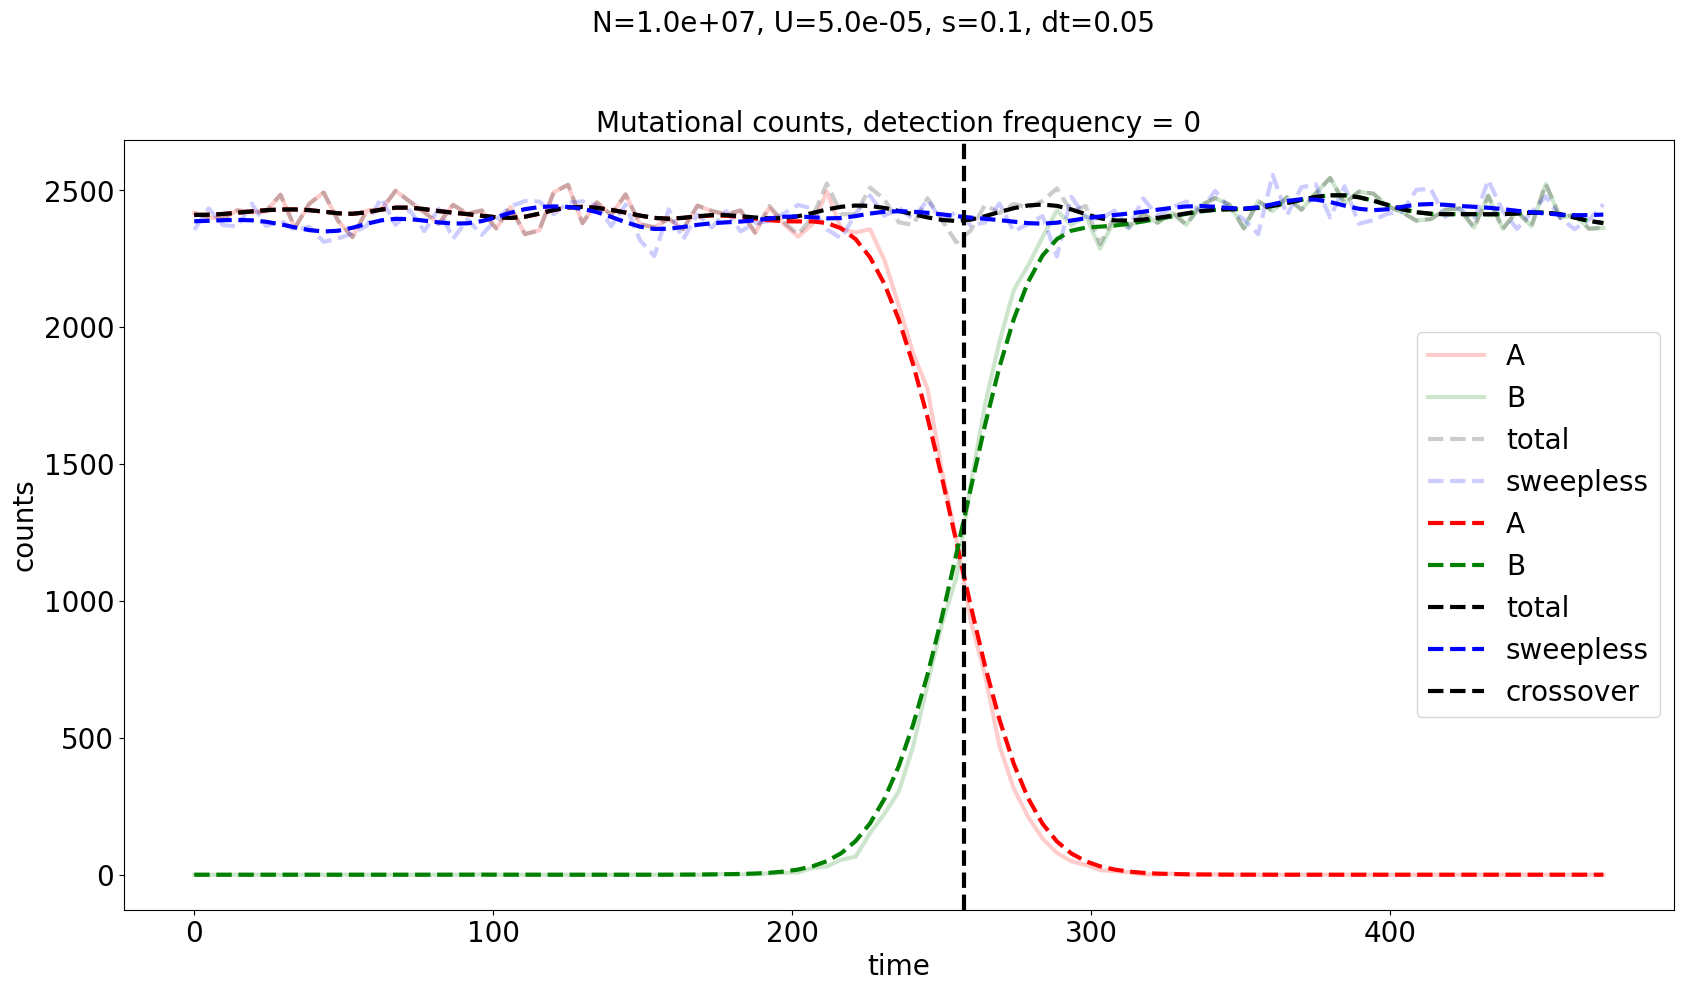

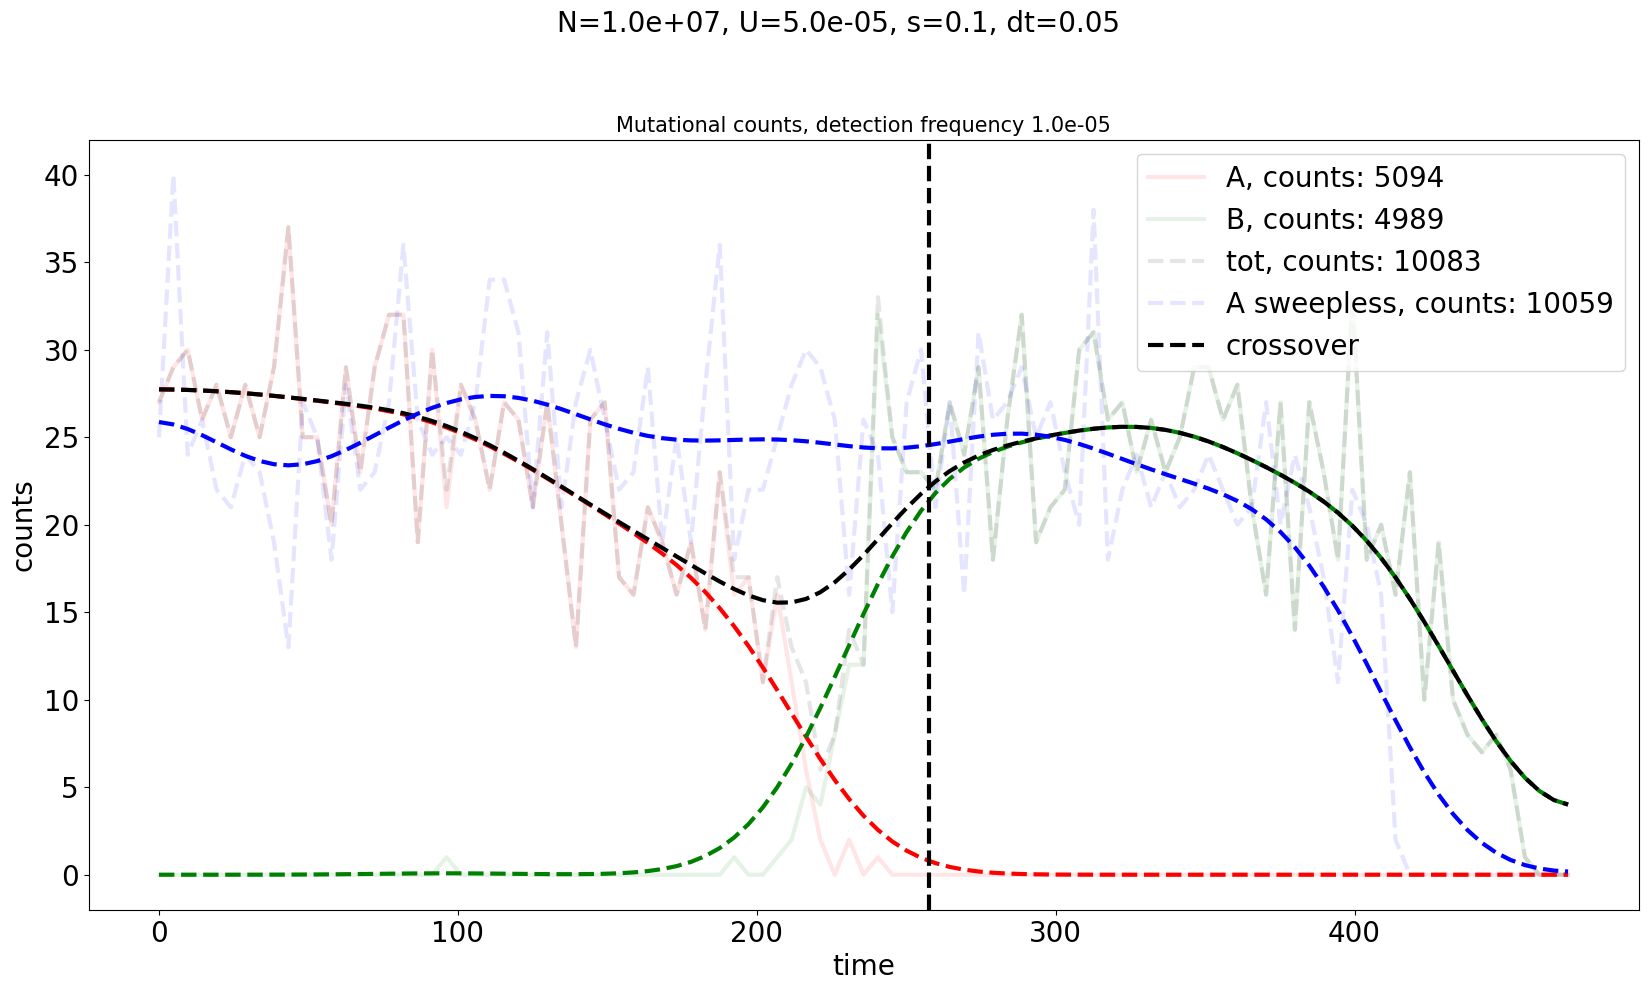

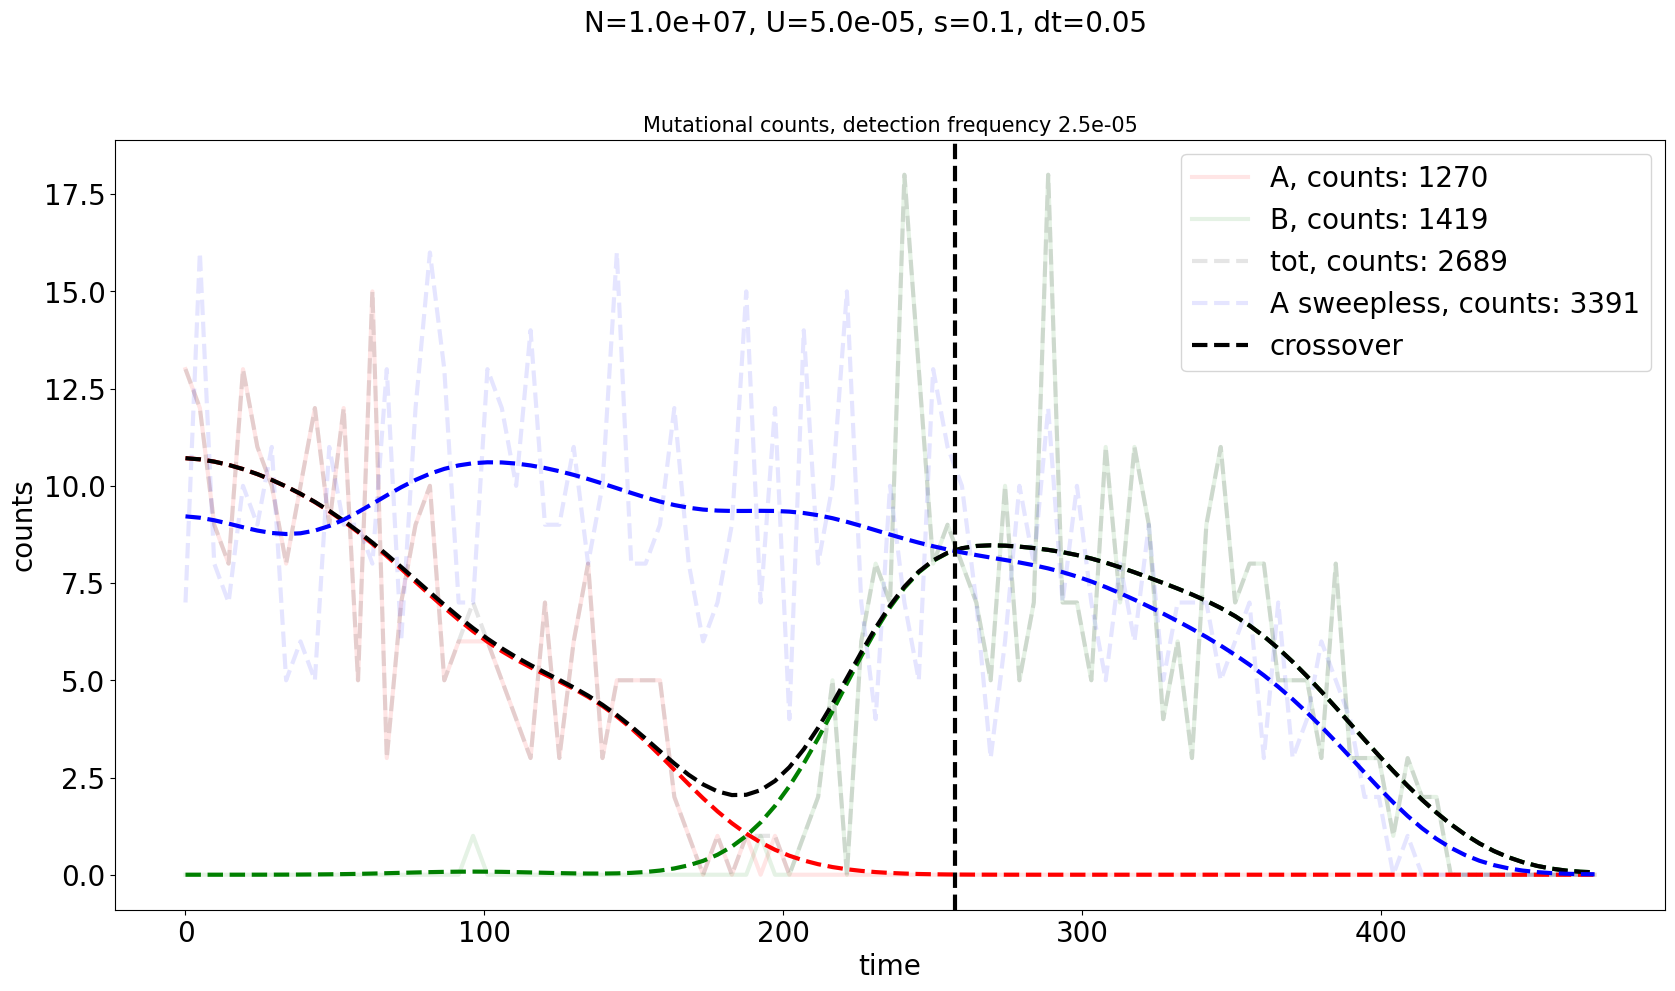

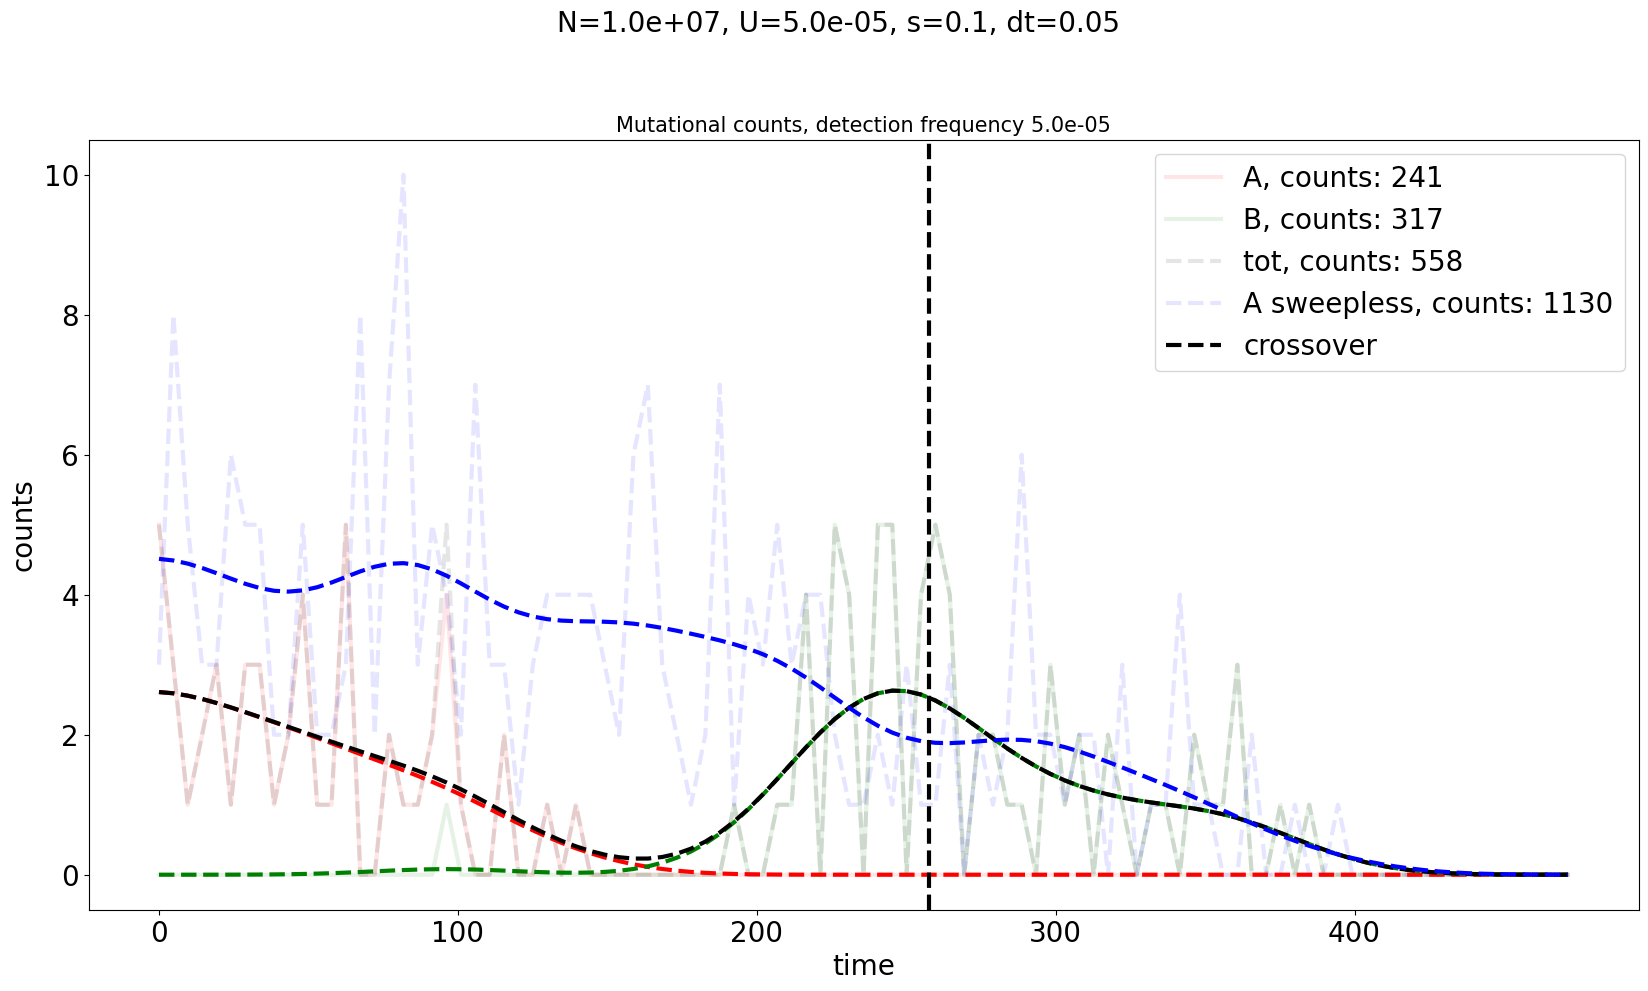

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
h_A,b_A,p_A = tb_A_hist_list[0] 
h_B,b_B,p_B = tb_B_hist_list [0] 
h_tot,b_tot,p_tot = tot_ts_hist_list[0] 
h_A_sweepless, b_A_sweepless, p_A_sweepless = tb_A_sweepless_hist_list[0]

h_A_smooth = gaussian_filter1d(h_A, sigma=2)
h_B_smooth = gaussian_filter1d(h_B, sigma=2)
h_tot_smooth = gaussian_filter1d(h_tot, sigma=2)
h_A_sweepless_smooth = gaussian_filter1d(h_A_sweepless, sigma=2)

ax.plot(b_tot[:-1],h_A, color='red',label='A',alpha=.2)
ax.plot(b_tot[:-1],h_B, color='green',label='B',alpha=.2)
ax.plot(b_tot[:-1],h_tot, color='black',label='total',ls= '--',alpha=.2)
ax.plot(b_A_sweepless[:-1],h_A_sweepless, label='sweepless',color='blue',ls= '--',alpha=.2)

ax.plot(b_tot[:-1],h_A_smooth, color='red',label='A',ls='--')
ax.plot(b_tot[:-1],h_B_smooth, color='green',label='B',ls='--')
ax.plot(b_tot[:-1],h_tot_smooth, color='black',label='total',ls= '--')
ax.plot(b_A_sweepless[:-1],h_A_sweepless_smooth, label='sweepless',color='blue',ls= '--')

crossover_ind = np.where(N_Bs>N_As)[0][0]
ax.axvline(ts[crossover_ind],color='black',ls='--',label='crossover')
fig.suptitle(f'N={N:.1e}, U={U:.1e}, s={s}, dt={dt}',fontsize=20, y=1.01)
ax.set_xlabel('time',fontsize=20)
ax.set_ylabel('counts',fontsize=20)
ax.set_title('Mutational counts, detection frequency = 0',fontsize=20)
# tax = ax.twinx()
# tax.plot(ts, N_As, color='green')
# tax.plot(ts, N_Bs, color='red')
ax.legend(loc='best',fontsize=20)
# tax.set_ylim(bottom=-1)
# tax.set_yscale('log')
print(f'counts: {len(tb_A)}, {len(tb_B)}')
# ax.set_yscale('log')

plt.savefig(output_folder+f'N_{N:.1e}_U_{U:.1e}_s_{s}_dt_{dt}_detection_0.pdf',bbox_inches='tight')

for detection_n in [100,250,500]:
    fig,ax = plt.subplots(1,1,figsize=(20,10))

    h_A,b_A,p_A = tb_A_hist_list[detection_n] 
    h_B,b_B,p_B = tb_B_hist_list [detection_n] 
    h_tot,b_tot,p_tot = tot_ts_hist_list[detection_n] 
    h_A_sweepless, b_A_sweepless, p_A_sweepless = tb_A_sweepless_hist_list[detection_n]

    h_A_smooth = gaussian_filter1d(h_A, sigma=5)
    h_B_smooth = gaussian_filter1d(h_B, sigma=5)
    h_tot_smooth = gaussian_filter1d(h_tot, sigma=5)
    h_A_sweepless_smooth = gaussian_filter1d(h_A_sweepless, sigma=5)

    ax.plot(b_tot[:-1],h_A, color='red', label = f'A, counts: {np.sum(h_A*np.diff(b_A)):.0f}', alpha=.1)
    ax.plot(b_tot[:-1],h_B, color='green', label = f'B, counts: {np.sum(h_B*np.diff(b_B)):.0f}', alpha=.1)
    ax.plot(b_tot[:-1],h_tot, color='black',ls= '--', label = f'tot, counts: {np.sum(h_tot*np.diff(b_tot)):.0f}', alpha=.1)
    ax.plot(b_A_sweepless[:-1],h_A_sweepless, color='blue',ls= '--', label = f'A sweepless, counts: {np.sum(h_A_sweepless*np.diff(b_A_sweepless)):.0f}', alpha=.1)

    ax.plot(b_tot[:-1],h_A_smooth, color='red',ls='--')
    ax.plot(b_tot[:-1],h_B_smooth, color='green',ls='--')
    ax.plot(b_tot[:-1],h_tot_smooth, color='black',ls= '--')
    ax.plot(b_A_sweepless[:-1],h_A_sweepless_smooth, color='blue',ls= '--')



    ax.axvline(ts[crossover_ind],color='black',ls='--',label='crossover')
    # tax = ax.twinx()
    # tax.plot(ts, N_As, color='green')
    # tax.plot(ts, N_Bs, color='red')
    # tax.set_ylim(bottom=-1)
    fig.suptitle(f'N={N:.1e}, U={U:.1e}, s={s}, dt={dt}',fontsize=20, y=1.01)
    ax.set_xlabel('time',fontsize=20)
    ax.set_ylabel('counts',fontsize=20)
    ax.set_title(f'Mutational counts, detection frequency {detection_n/N:.1e}',fontsize=15)
    ax.legend(loc='best',fontsize=20)
    print(f'counts: {len(tb_A)}, {len(tb_B)}')
    plt.savefig(output_folder+f'N_{N:.1e}_U_{U:.1e}_s_{s}_dt_{dt}_detection_{detection_n}.pdf',bbox_inches='tight')

In [ ]:
max_freqs_A = np.max(A,axis=0)/N
max_freqs_B = np.max(B,axis=0)/N
max_freqs_joint = np.concatenate([max_freqs_A,max_freqs_B])

max_freqs_A_sweepless = np.max(A_sweepless,axis=0)/N

Text(0, 0.5, 'inverse cumulative density')

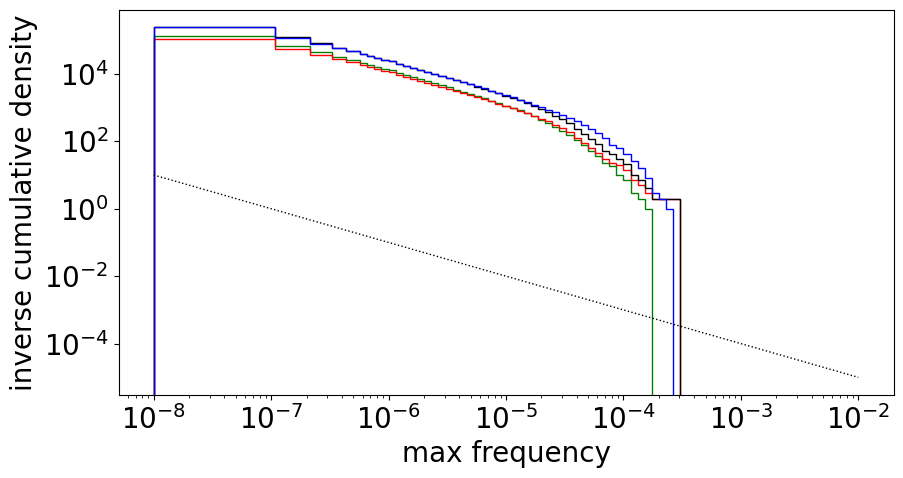

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.hist(max_freqs_A, bins=np.logspace(-np.log10(10*N),-2,100),histtype='step', cumulative=-1,density= 0,label = 'A', color='green');
ax.hist(max_freqs_B, bins=np.logspace(-np.log10(10*N),-2,100),histtype='step', cumulative=-1,density= 0,label = 'B', color='red');
ax.hist(max_freqs_joint, bins=np.logspace(-np.log10(10*N),-2,100),histtype='step', cumulative=-1,density= 0, color='black',label = 'total');
ax.hist(max_freqs_A_sweepless, bins=np.logspace(-np.log10(10*N),-2,100),histtype='step', cumulative=-1,density= 0, color='blue',label = 'sweepless');

xs_plot = np.logspace(-np.log10(10*N),-2,100)
ax.plot(xs_plot, 10 * xs_plot[0]/xs_plot , label='theory', color='black',lw=1,ls=':')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('max frequency',fontsize=20)
ax.set_ylabel('inverse cumulative density',fontsize=20)